In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.backends.backend_pdf
import collections
import glob
import os

from IPython.display import HTML

# Identifying genes which have opposite localization between celltypes

Using the gene/celltype table

Searching through all metrics and all datasets, even those without replicates.

Biological and technical replicates are averaged to create a single dataset.

Then genes are identified which have at least one significant cell-type with a positive, and one with a negative median score.

These median values of these genes are then visualized in a grid of stripplots

BICCN peripheral


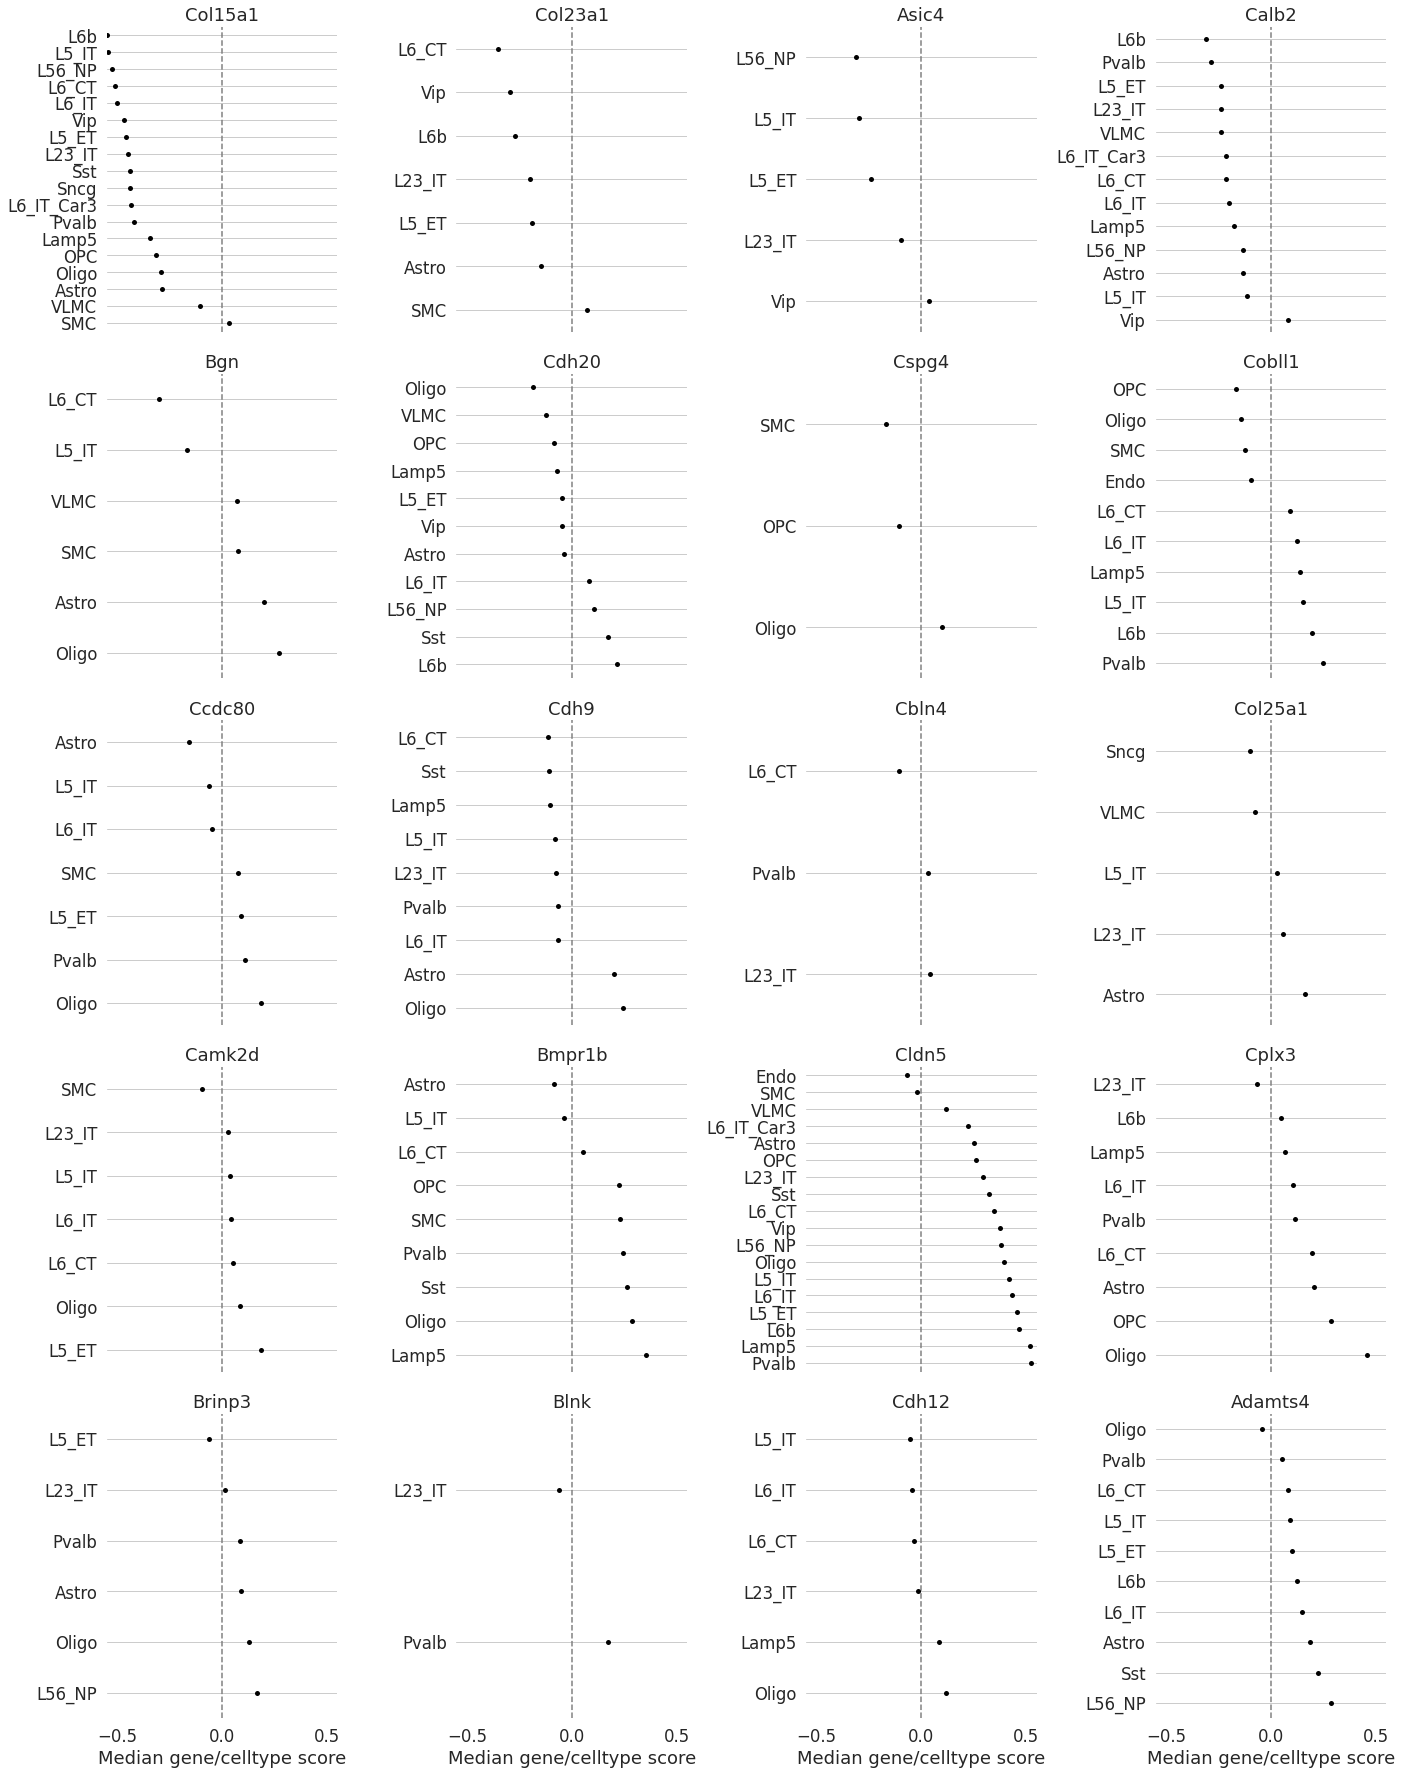

BICCN central


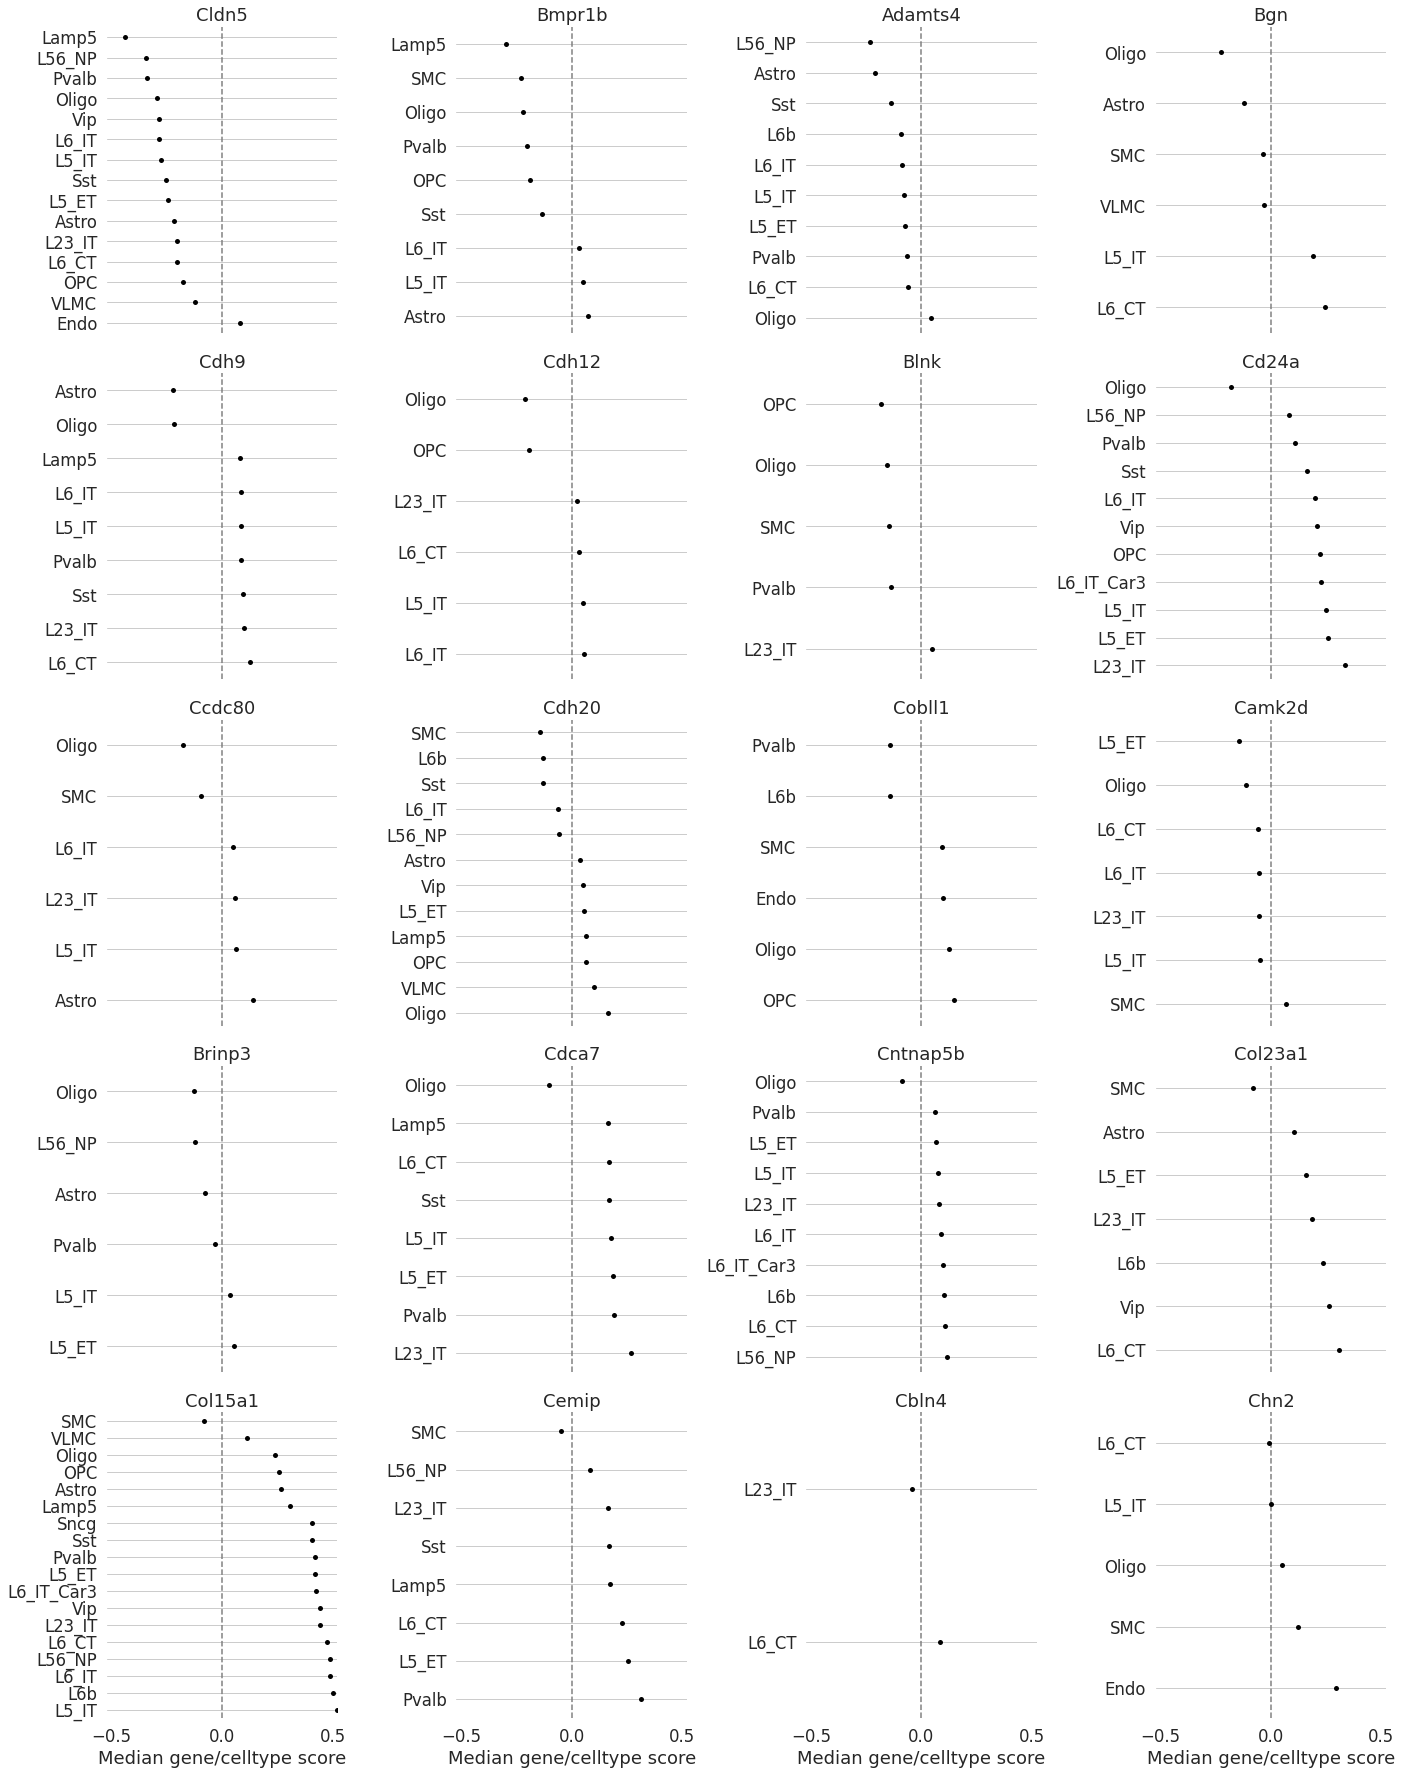

BICCN radial


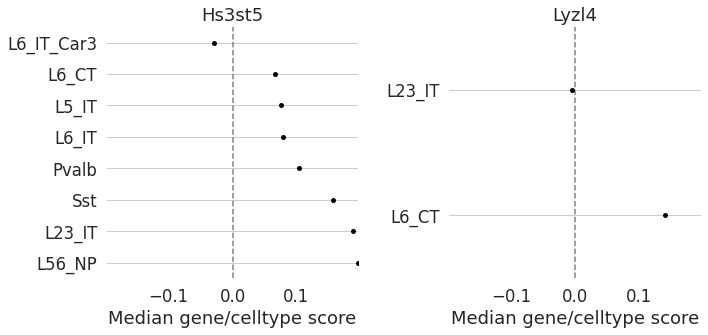

BICCN punctate


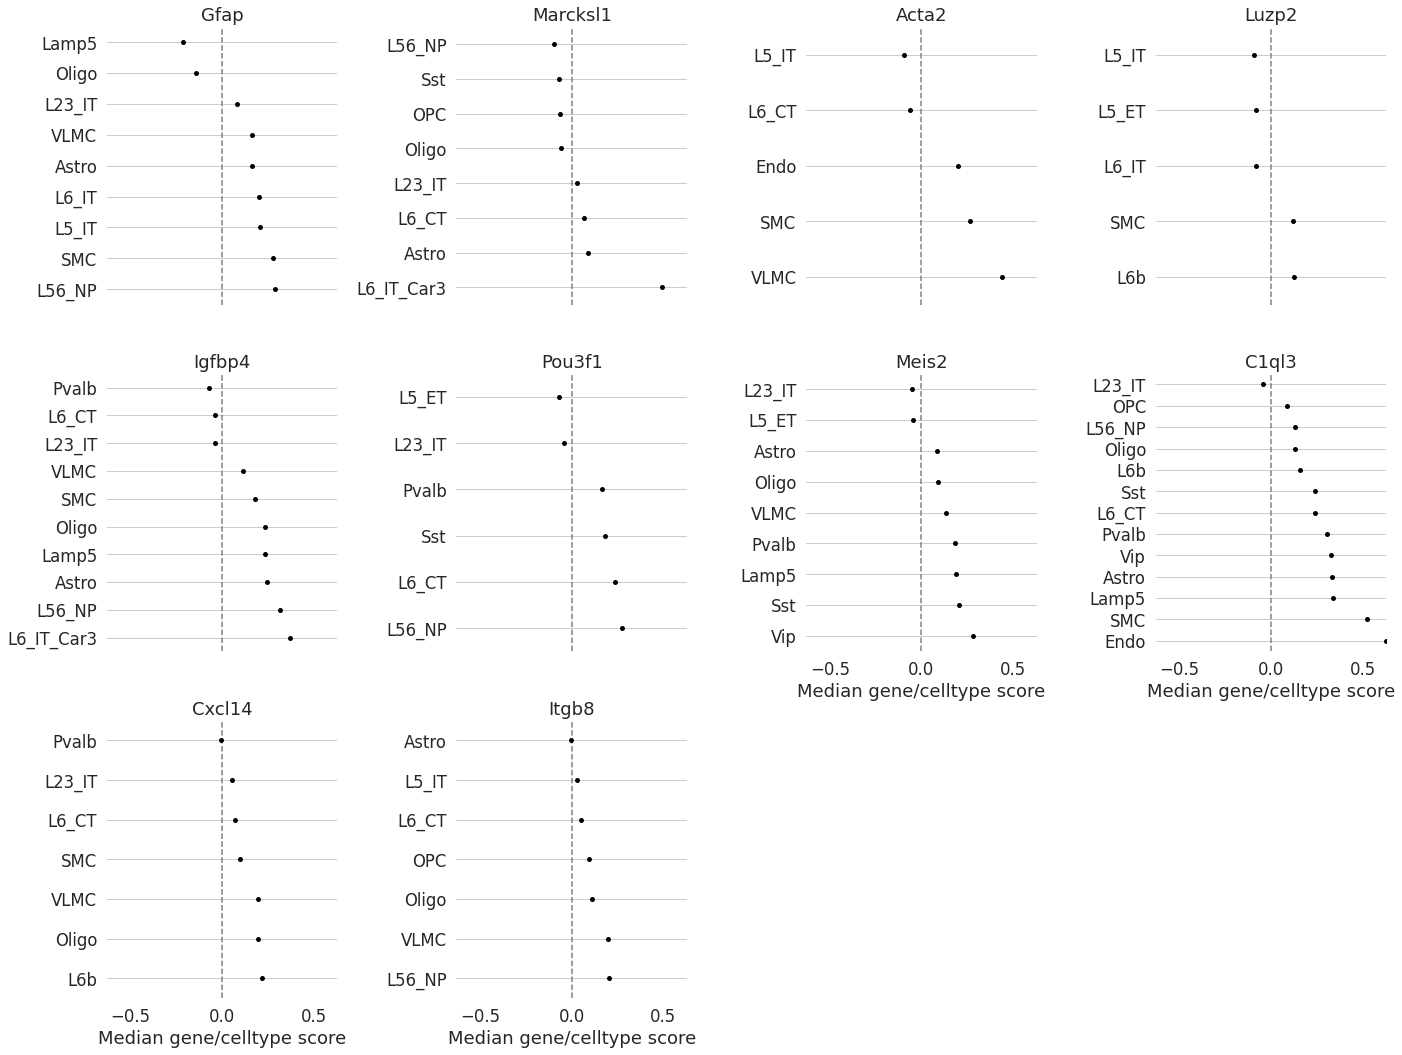

SeqFISH+ peripheral
SeqFISH+ central


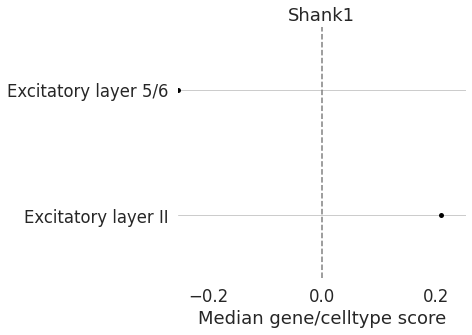

SeqFISH+ radial


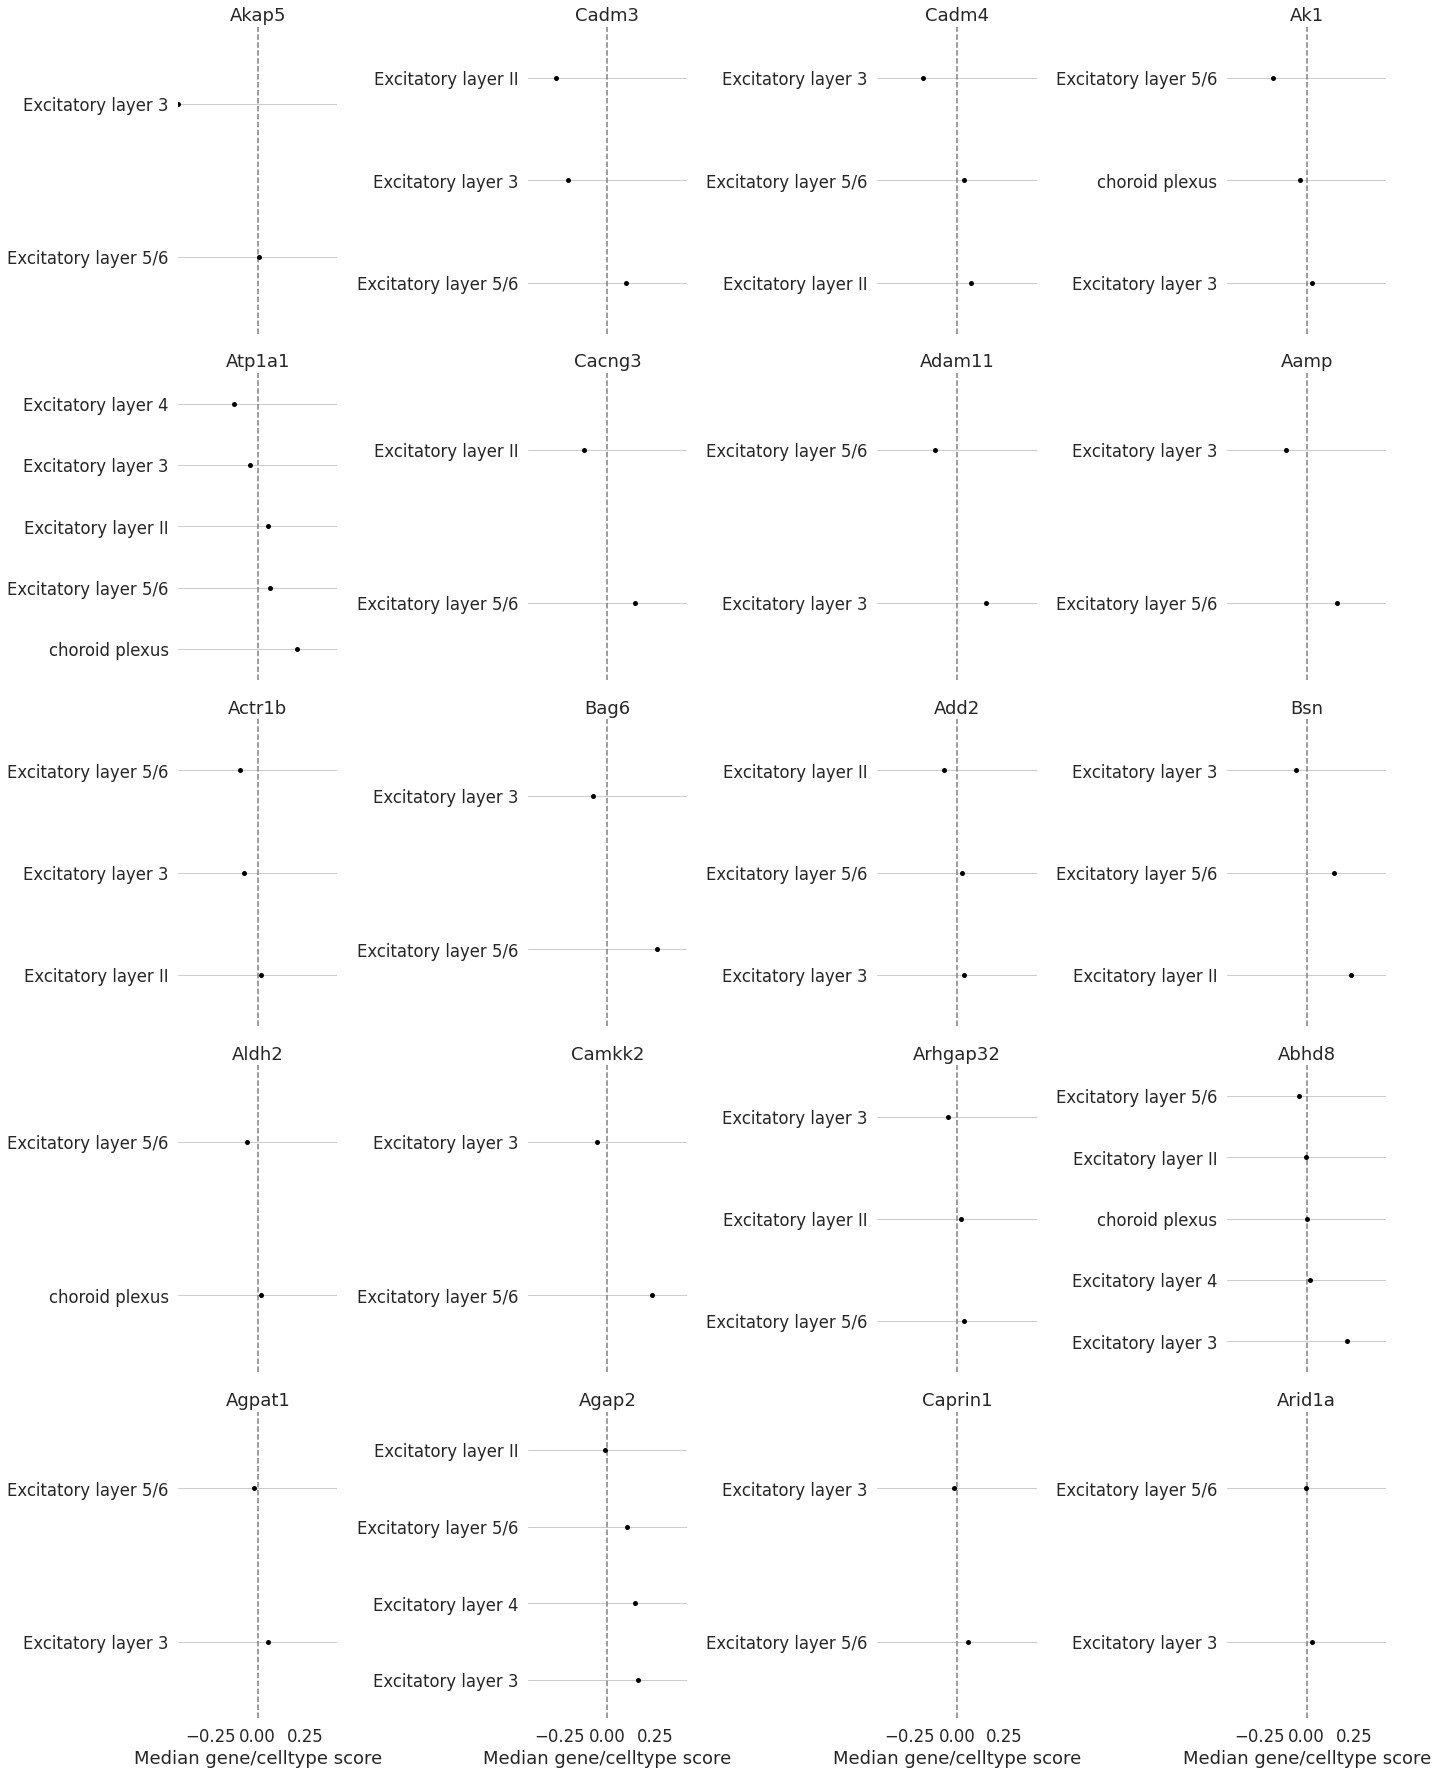

SeqFISH+ punctate


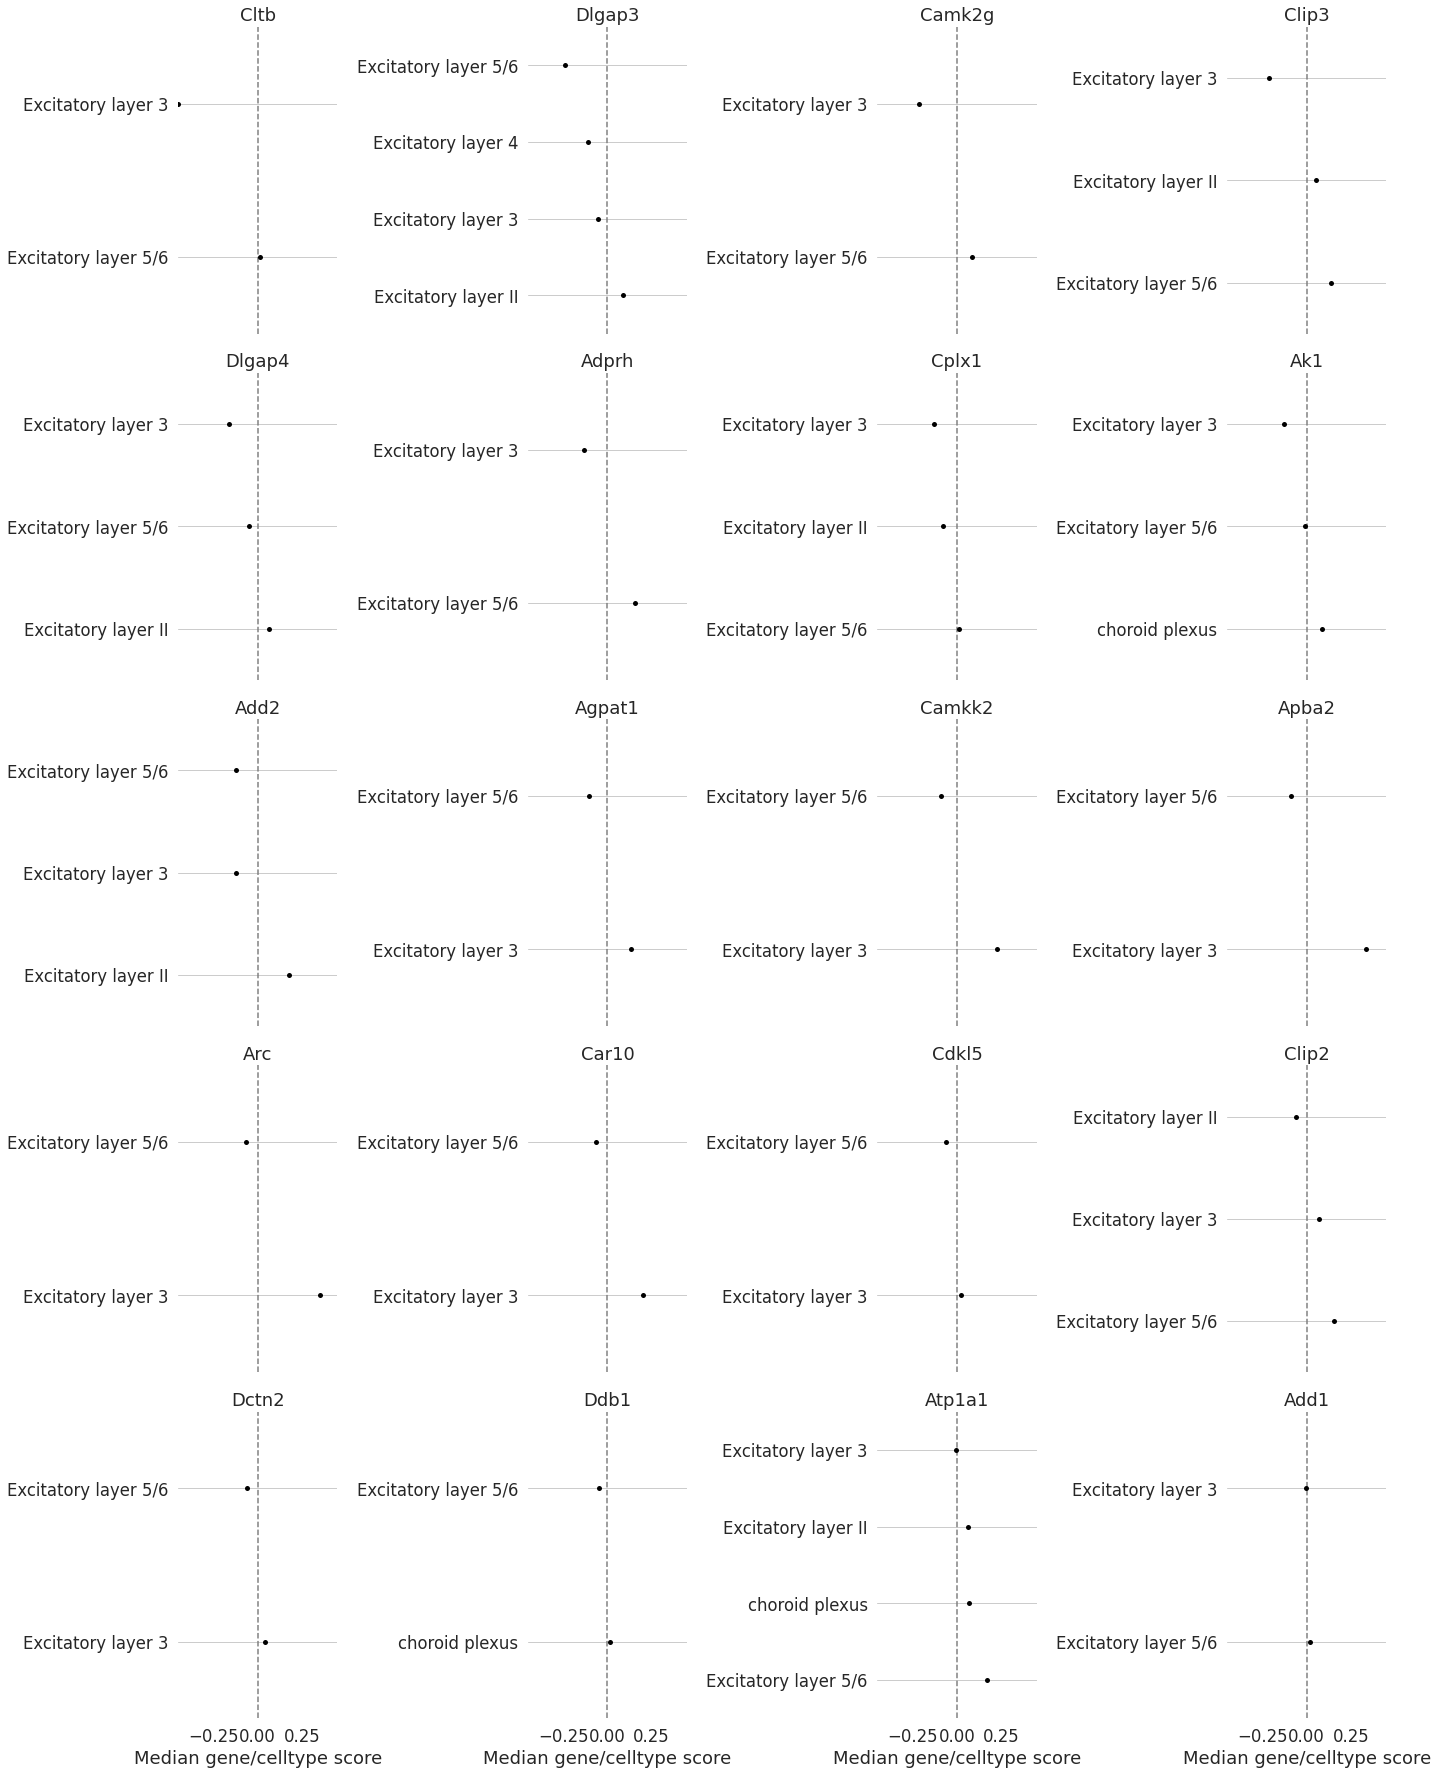

CZB_Kidney peripheral


/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/dev_env/lib64/python3.6/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


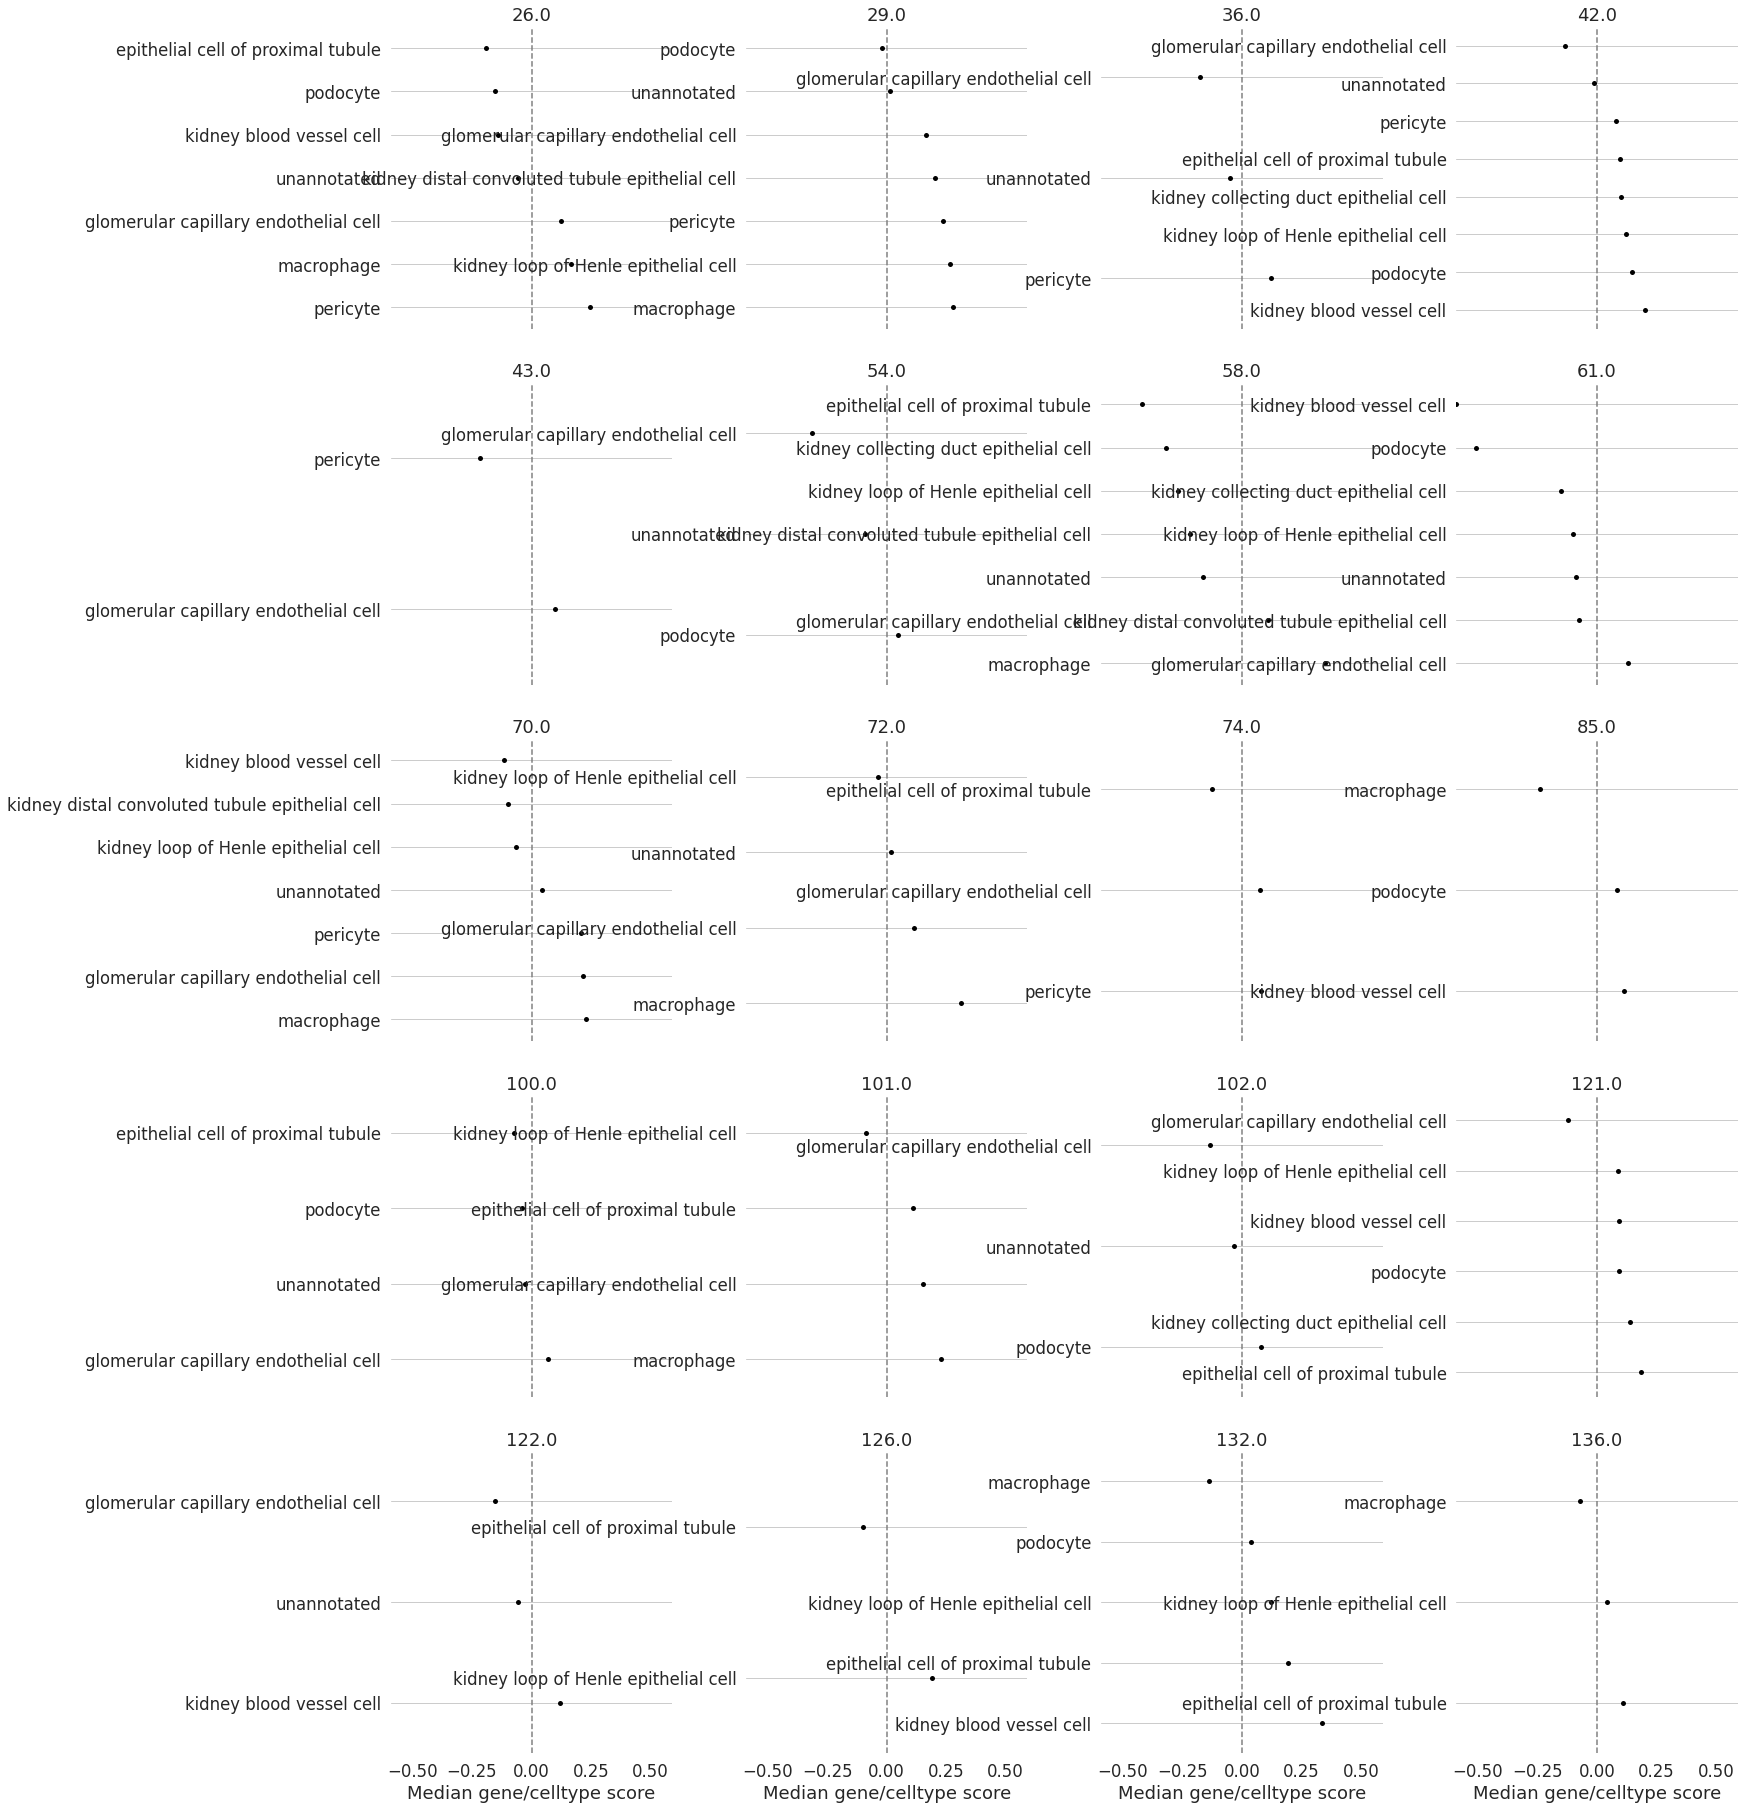

CZB_Kidney central


/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/dev_env/lib64/python3.6/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


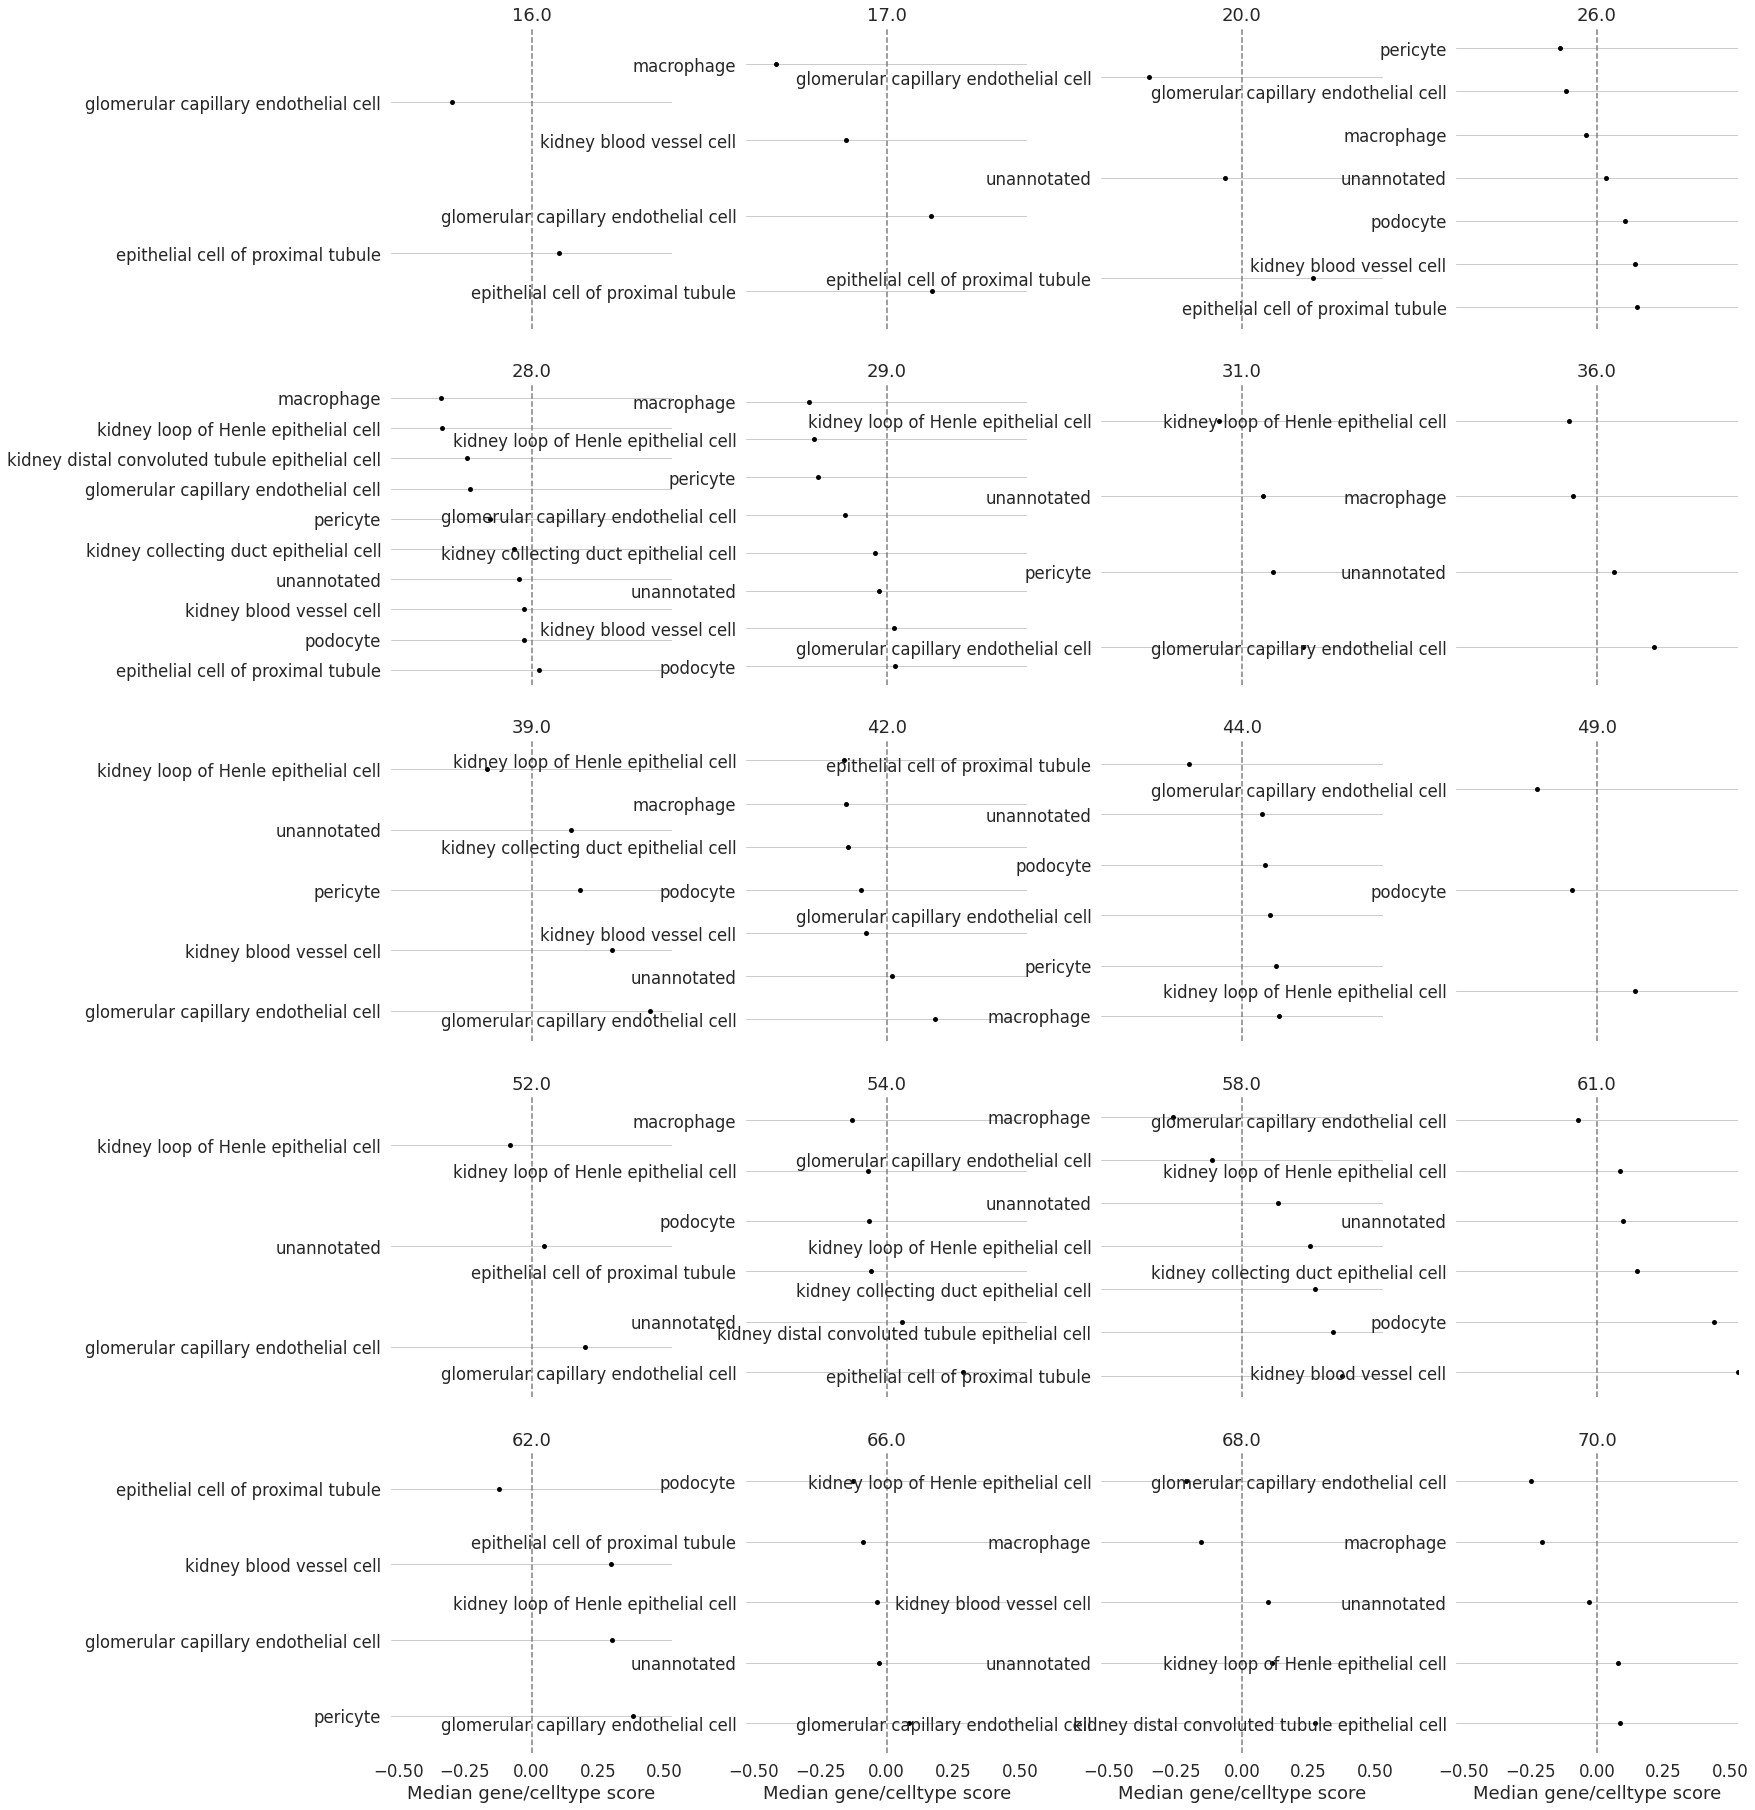

CZB_Kidney radial


/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/dev_env/lib64/python3.6/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


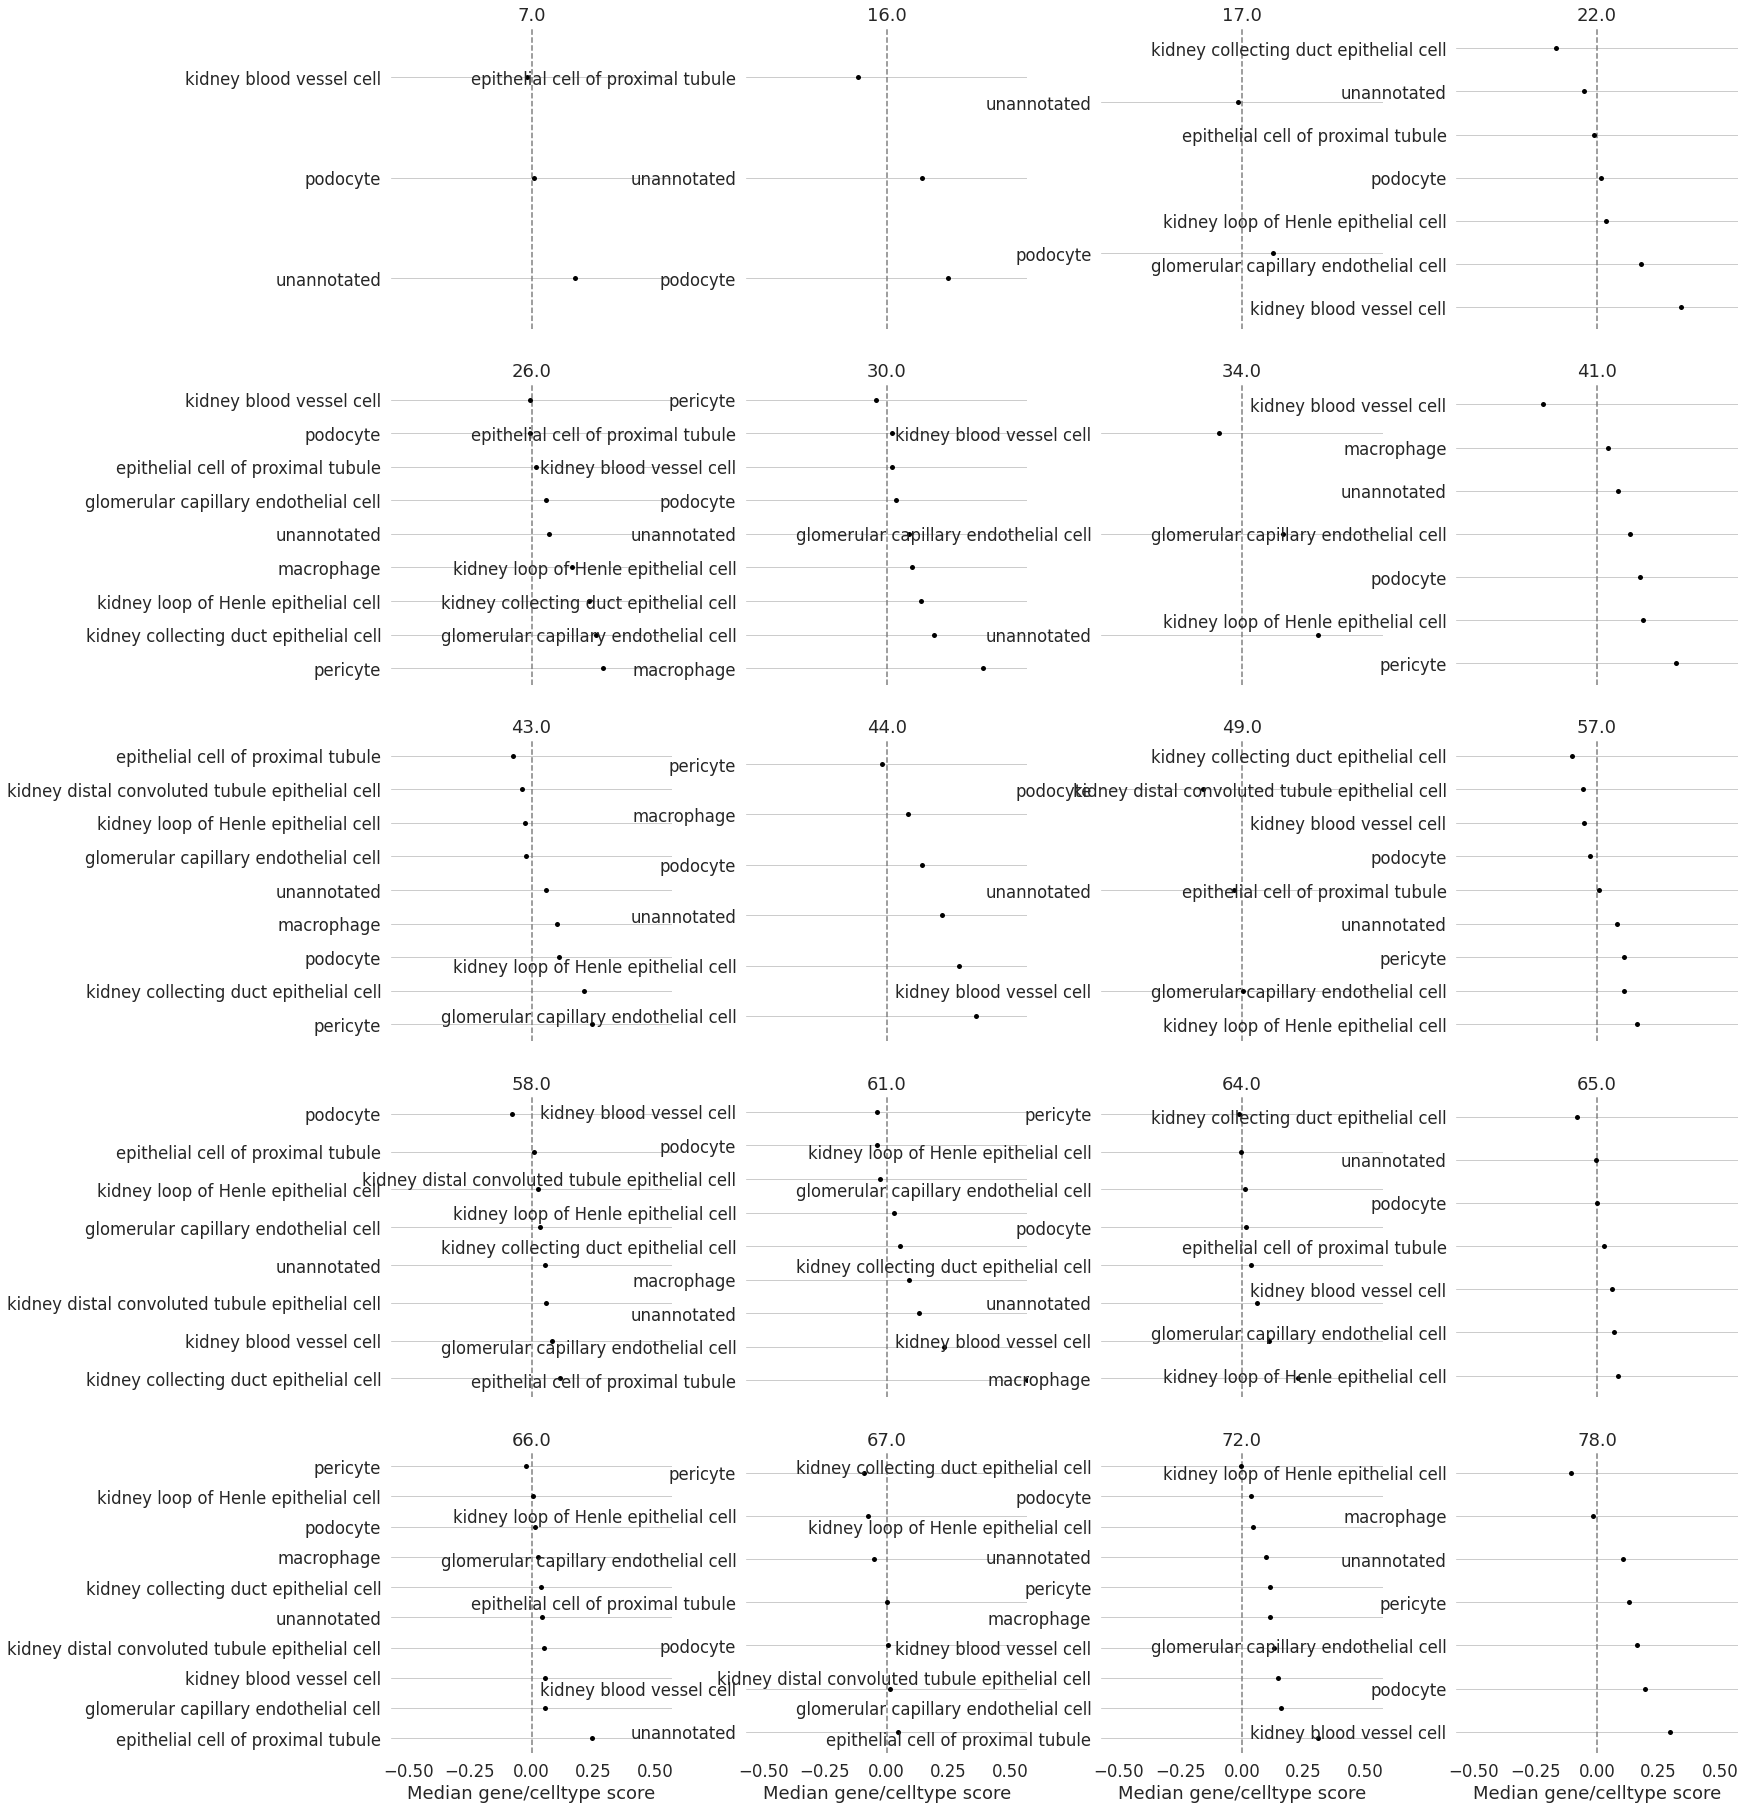

CZB_Kidney punctate


/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/dev_env/lib64/python3.6/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


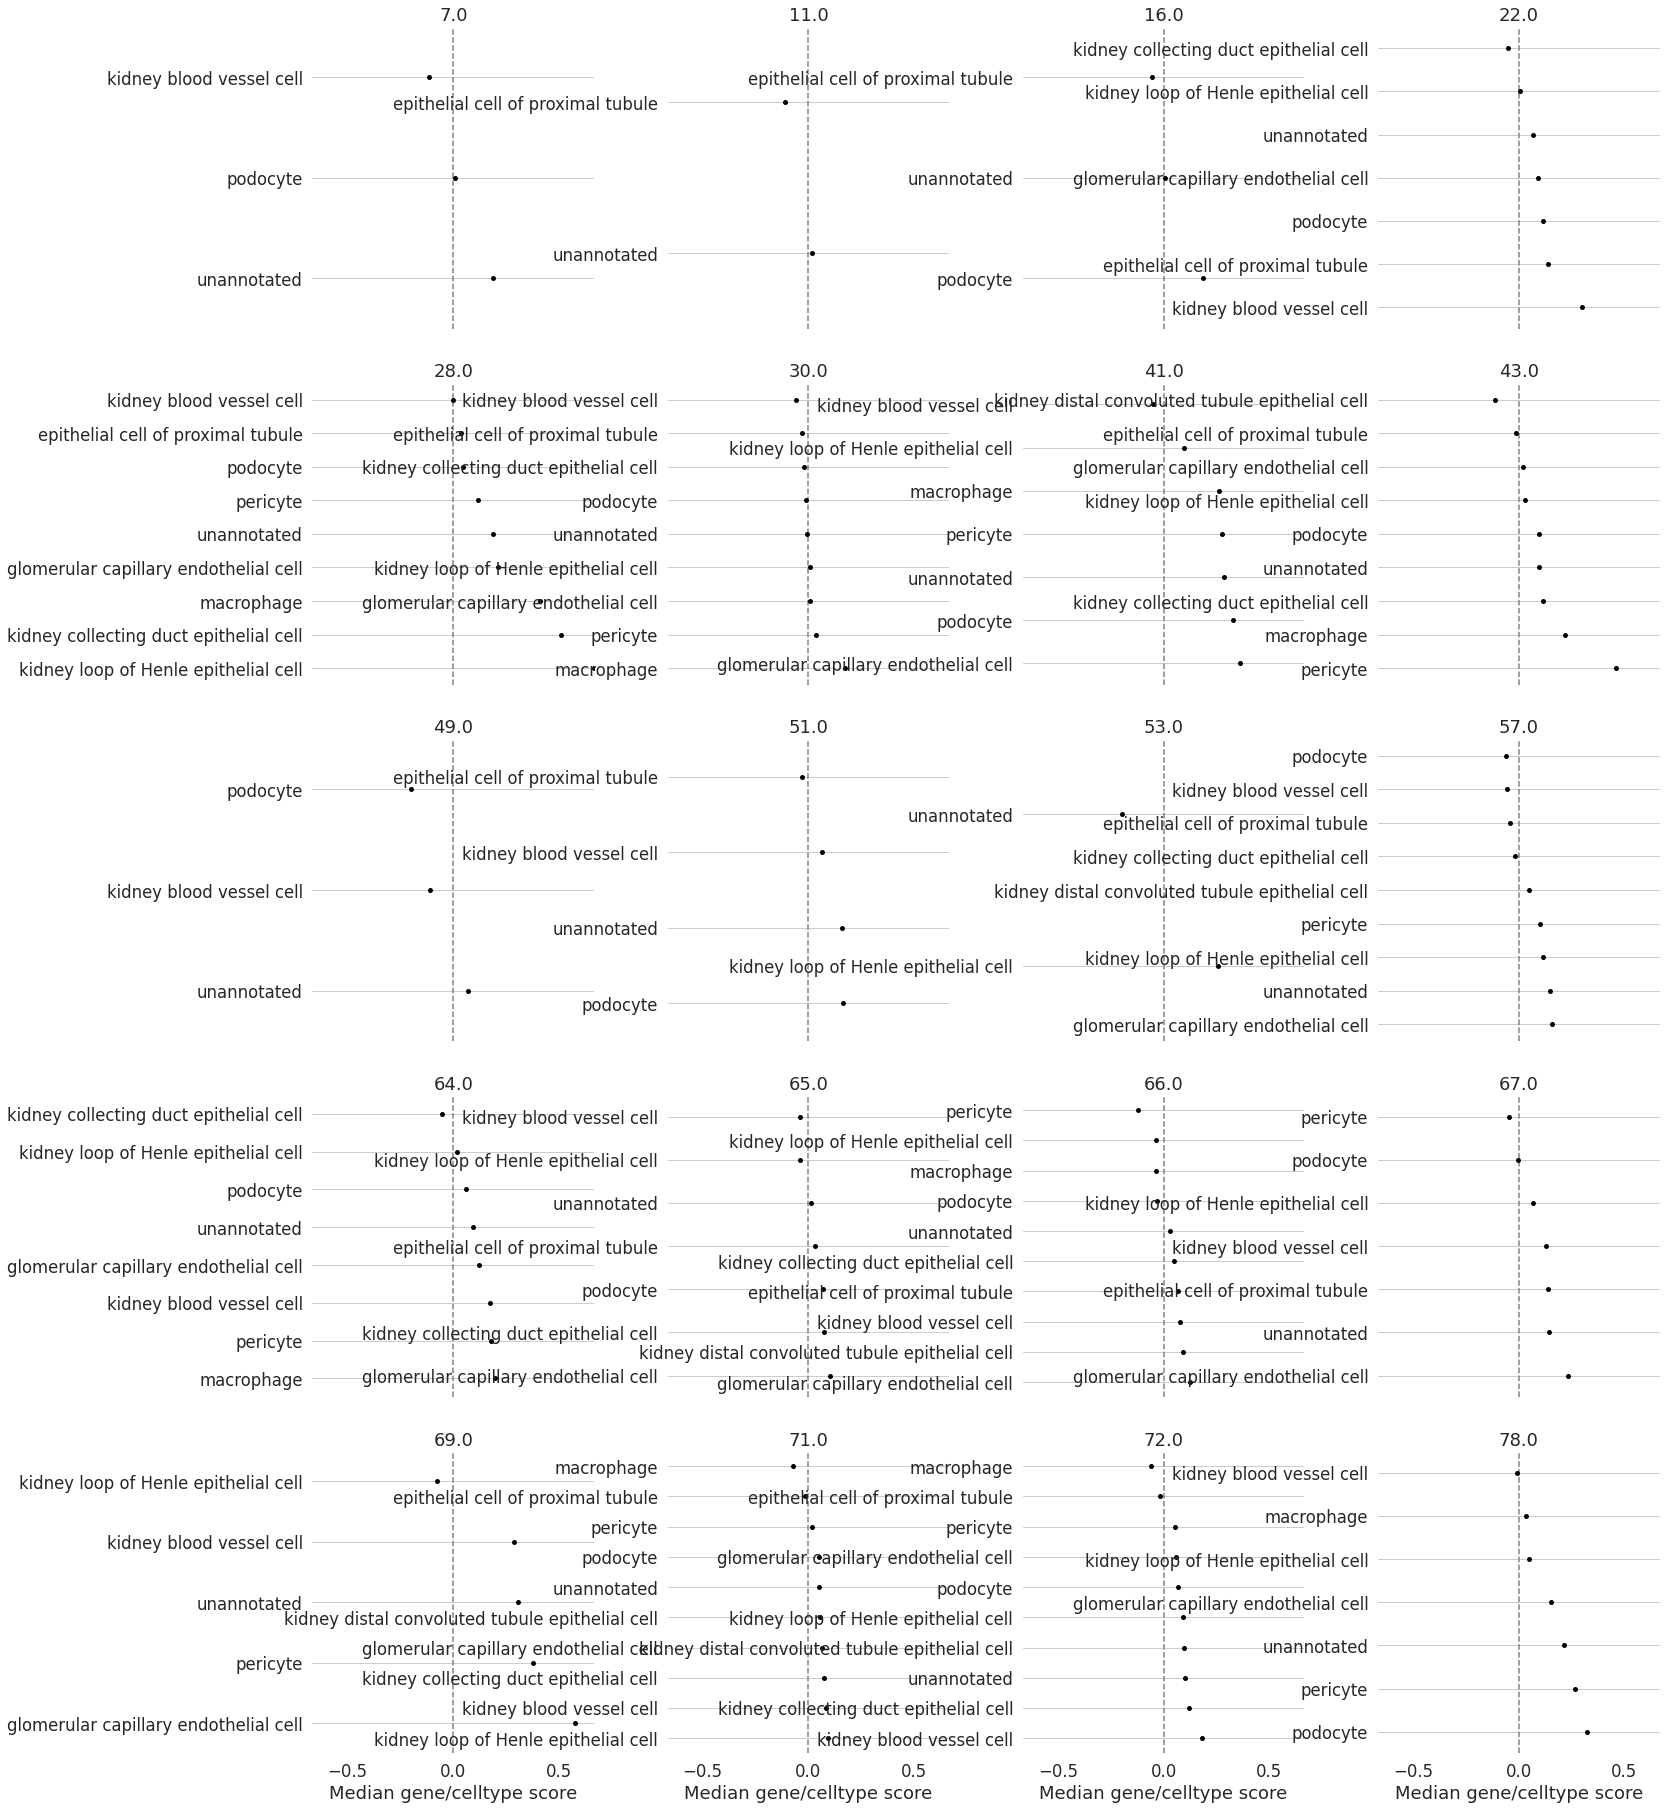

CZB_Liver peripheral


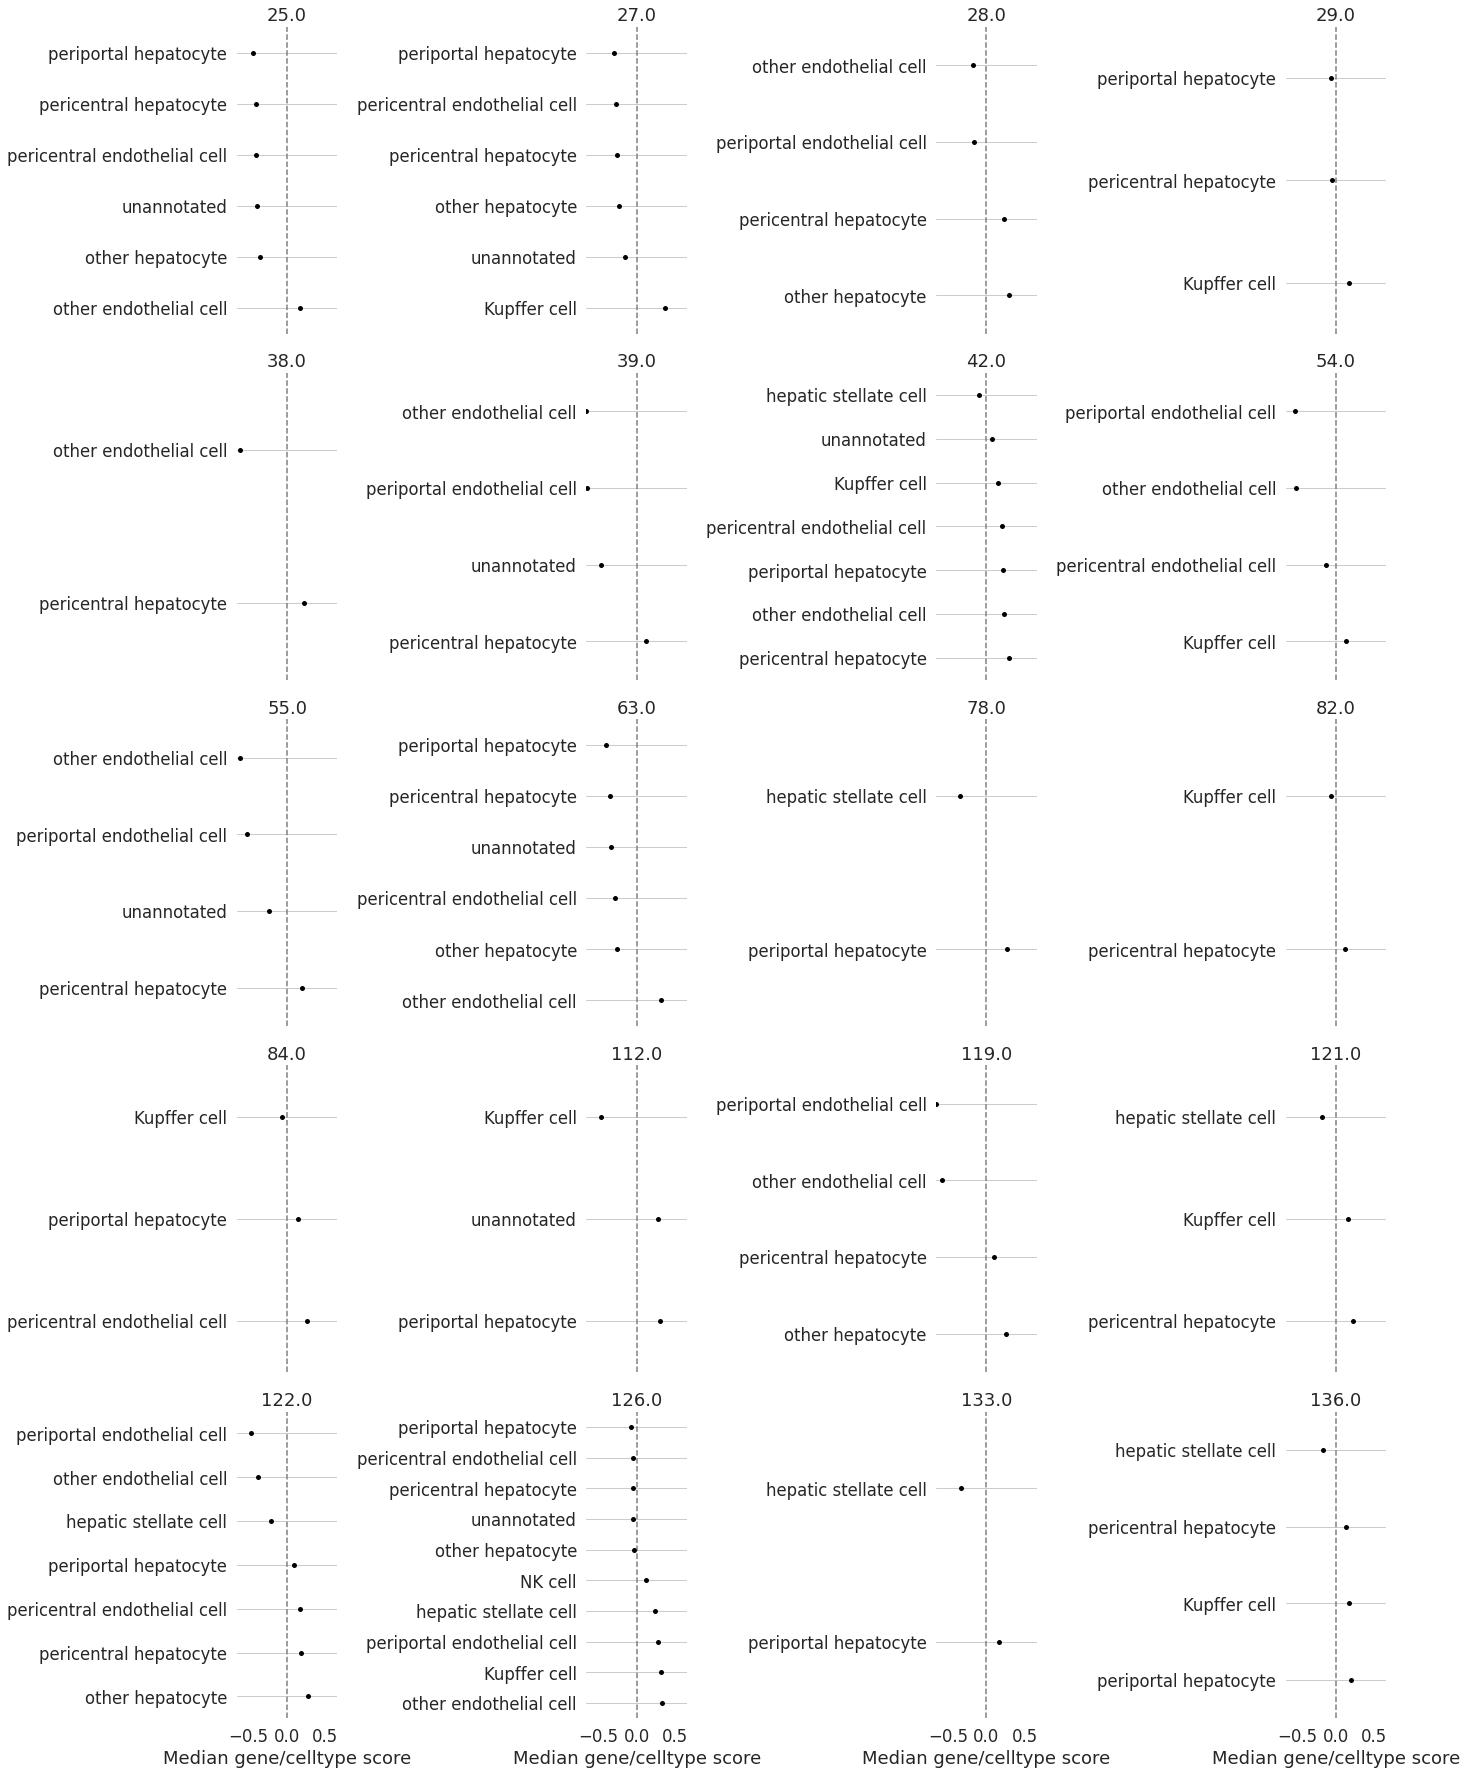

CZB_Liver central


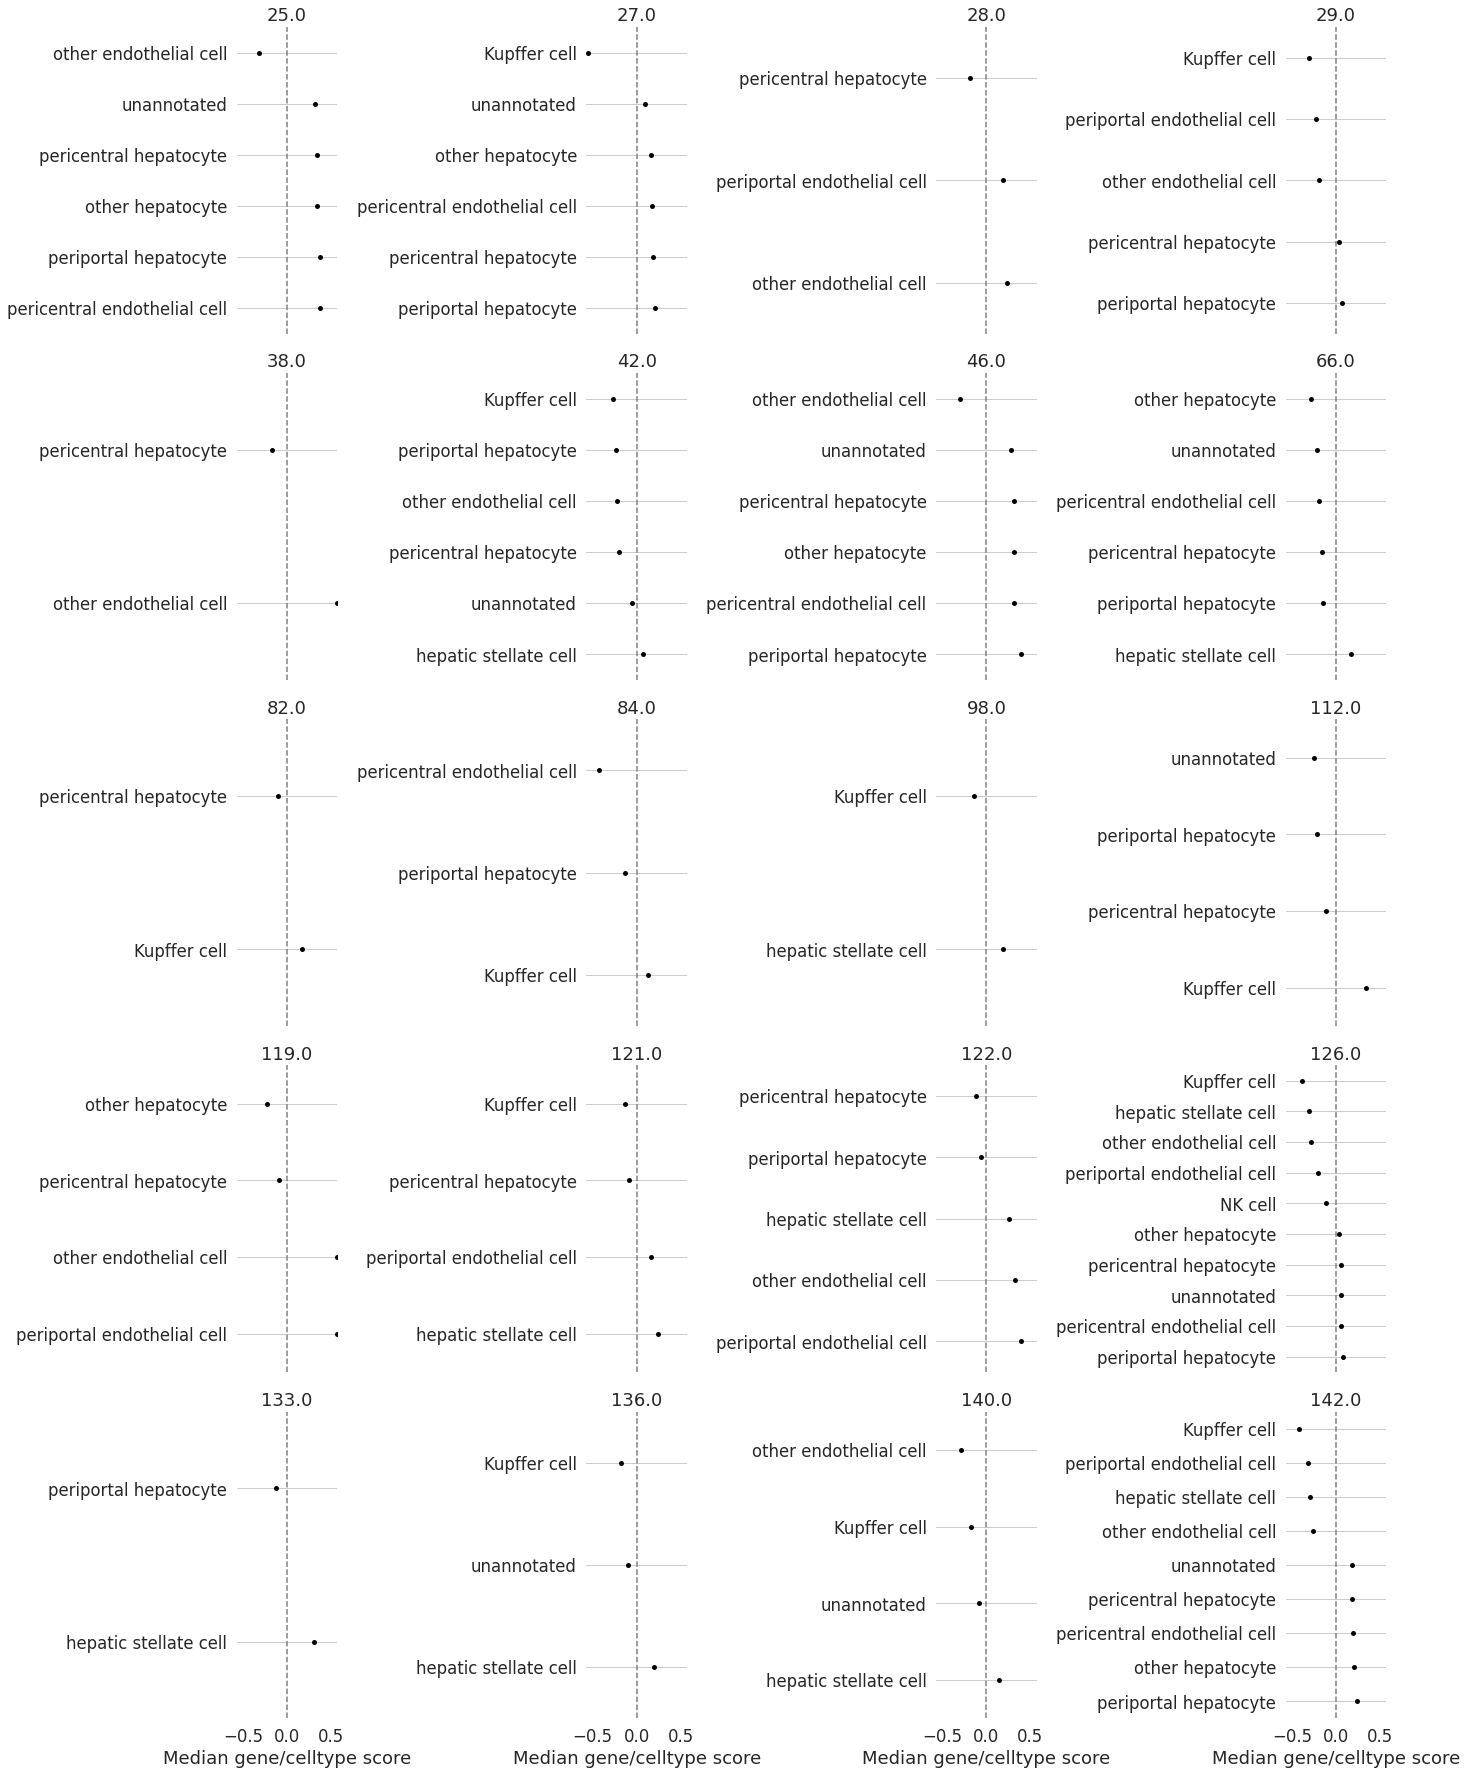

CZB_Liver radial


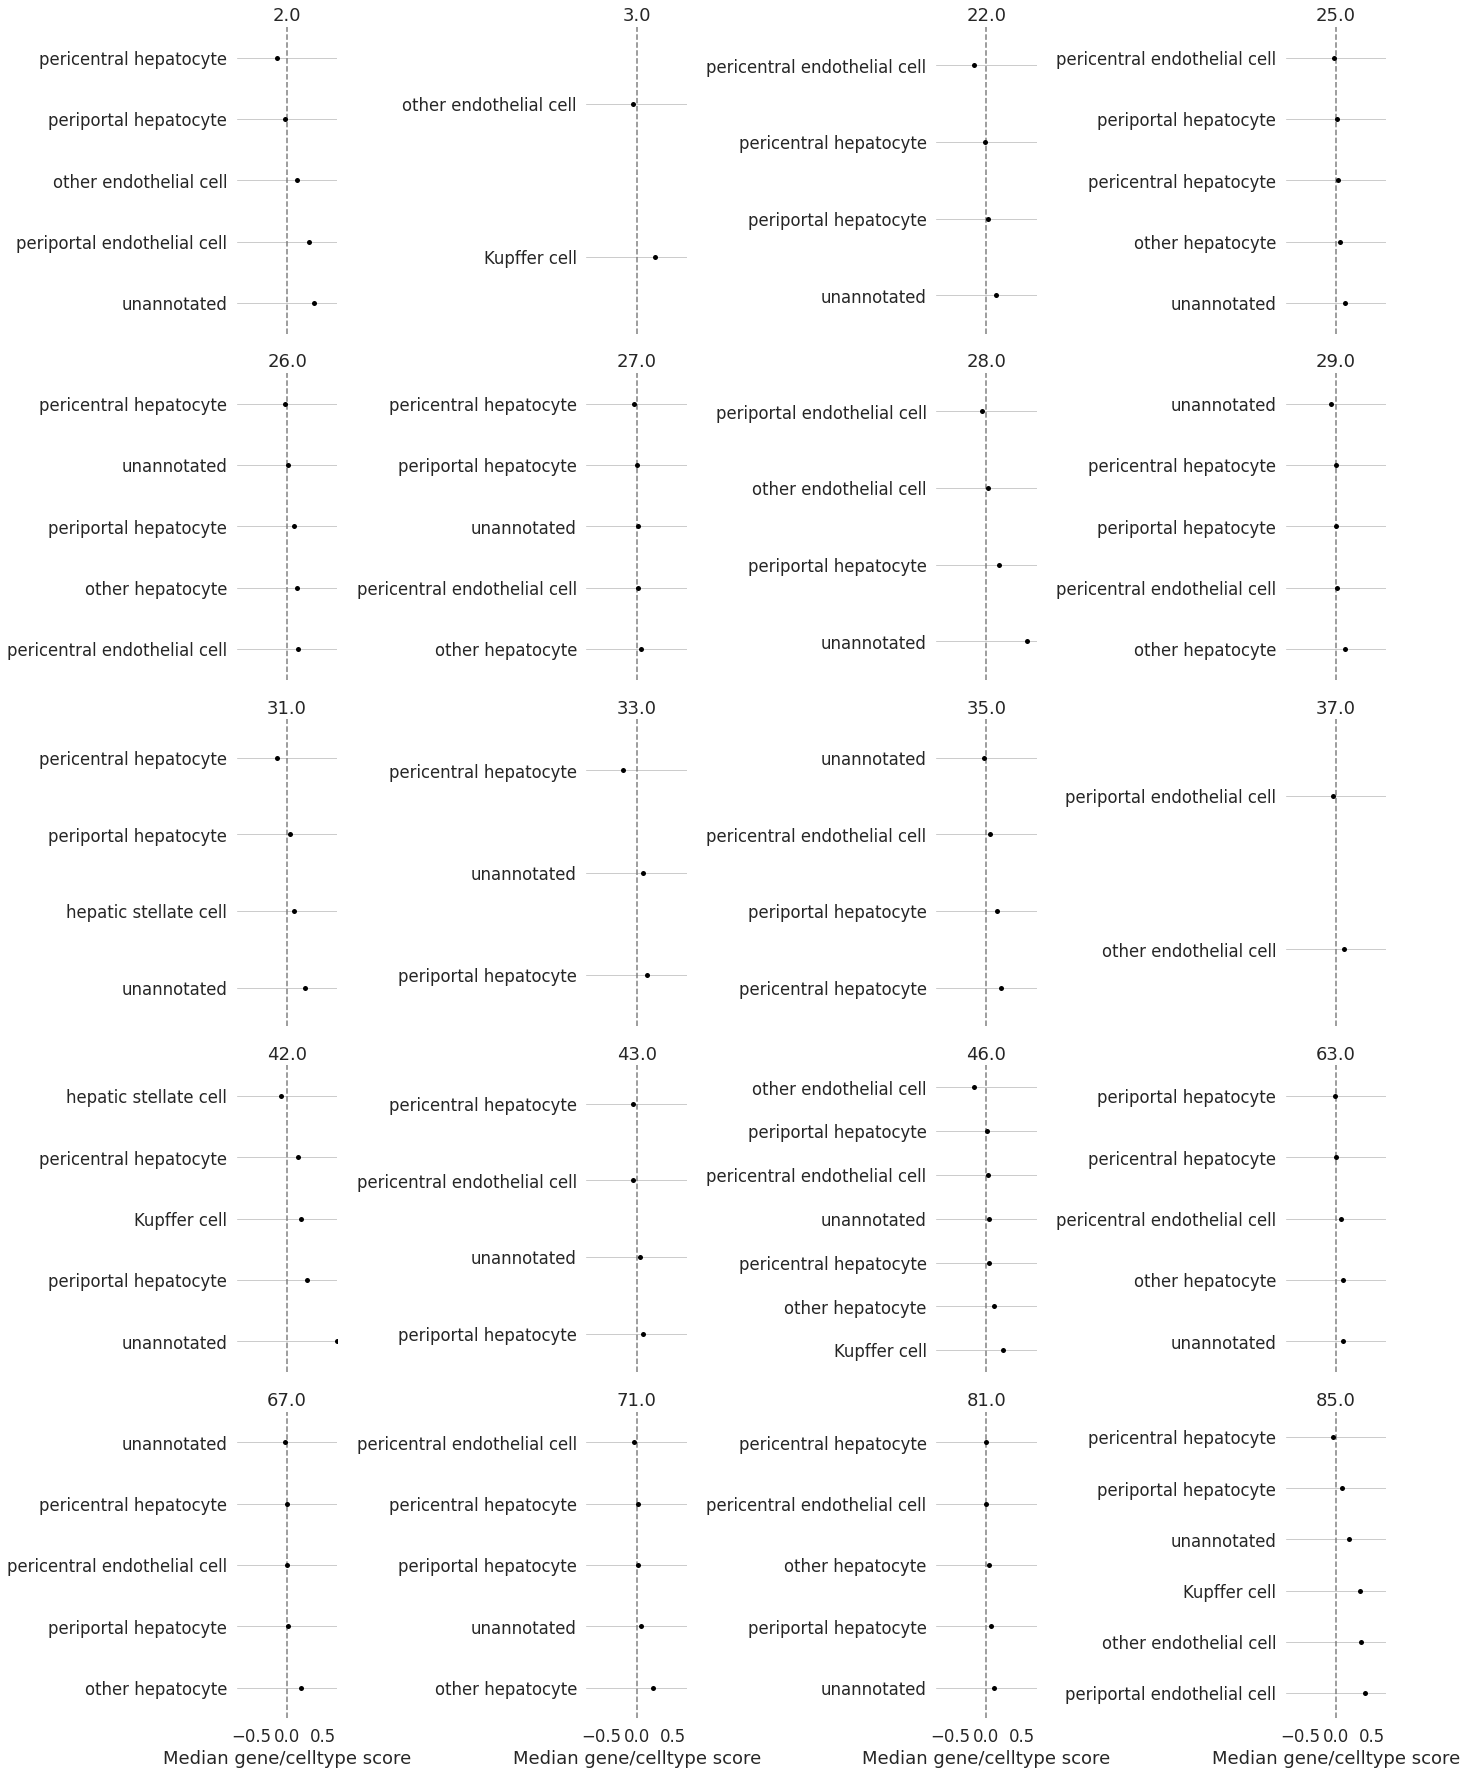

CZB_Liver punctate


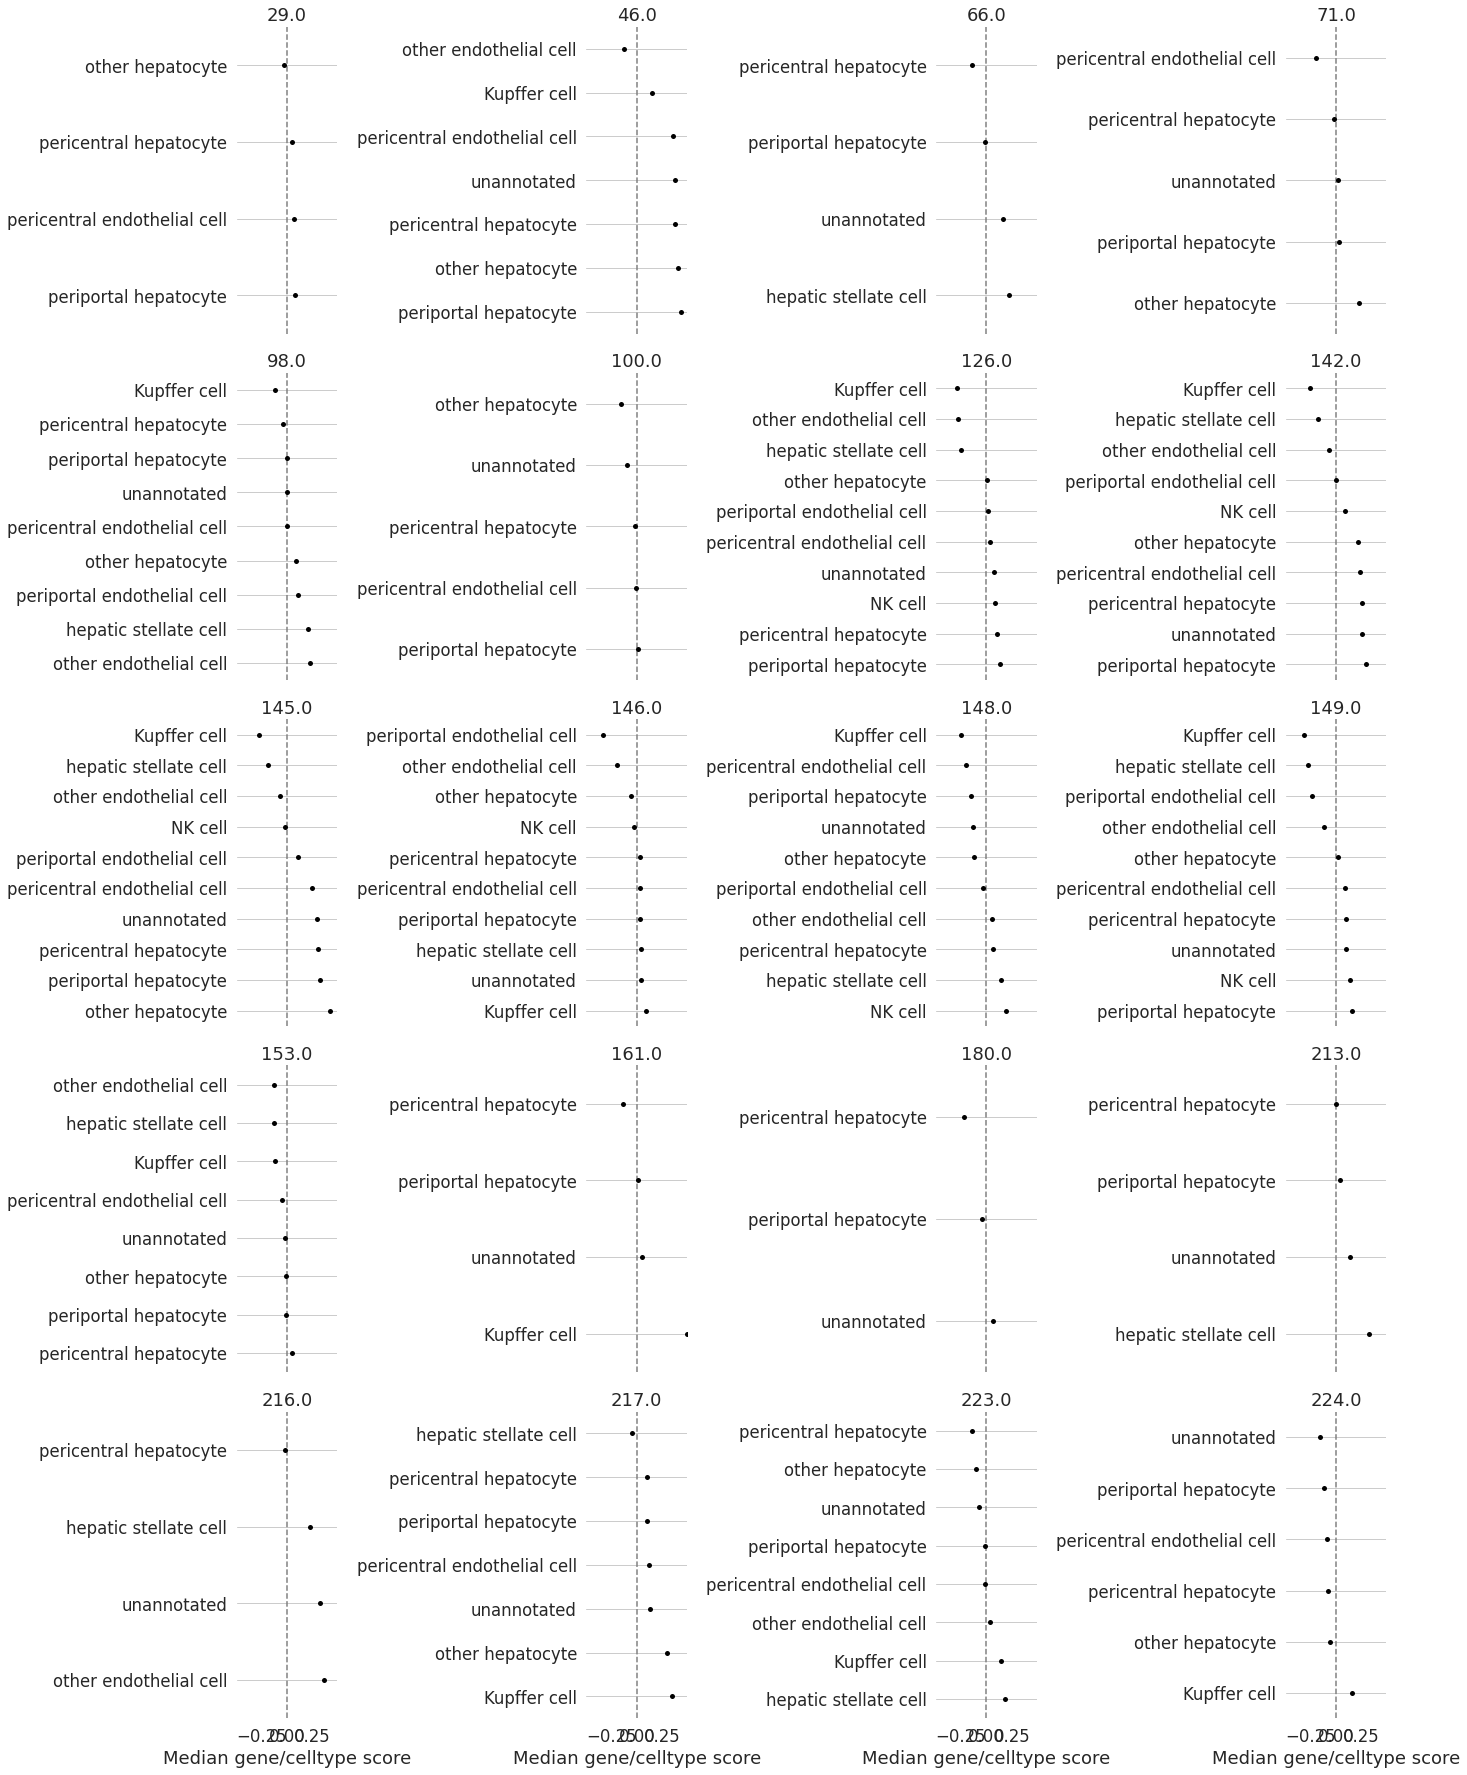

vz_Brainmap peripheral


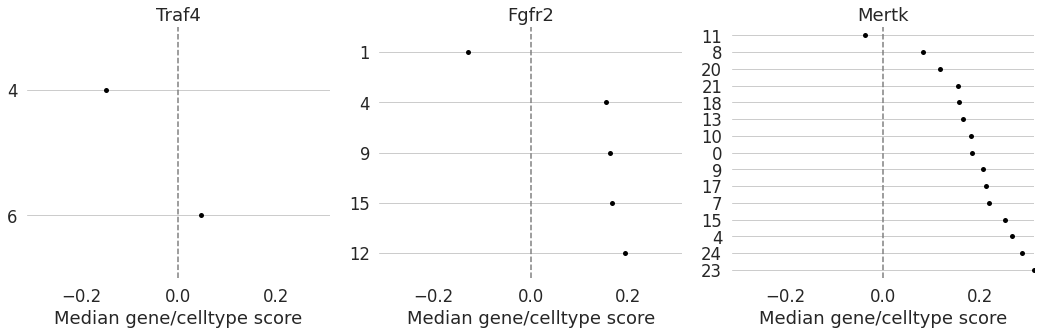

vz_Brainmap central


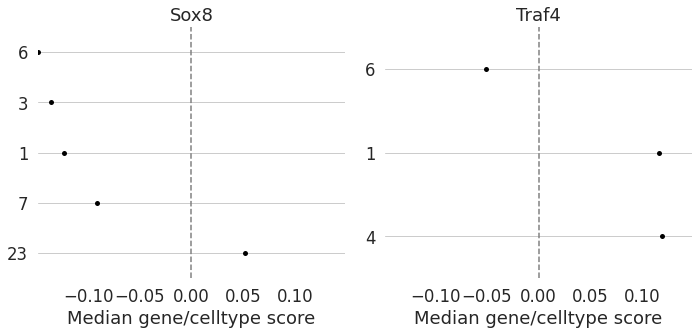

vz_Brainmap radial
vz_Brainmap punctate


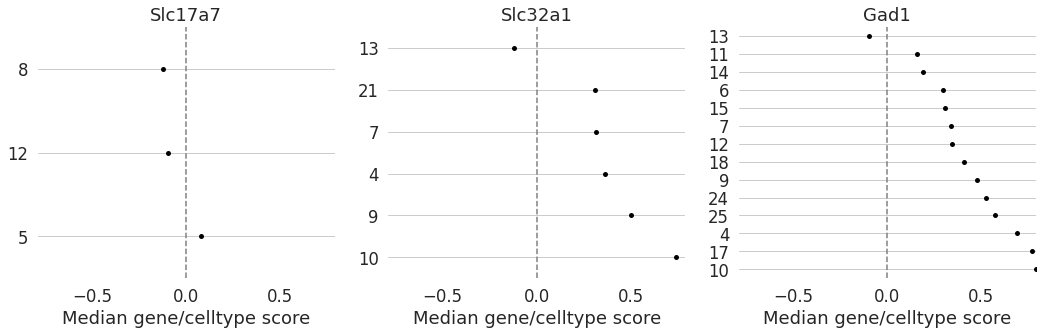

vz_Liver peripheral


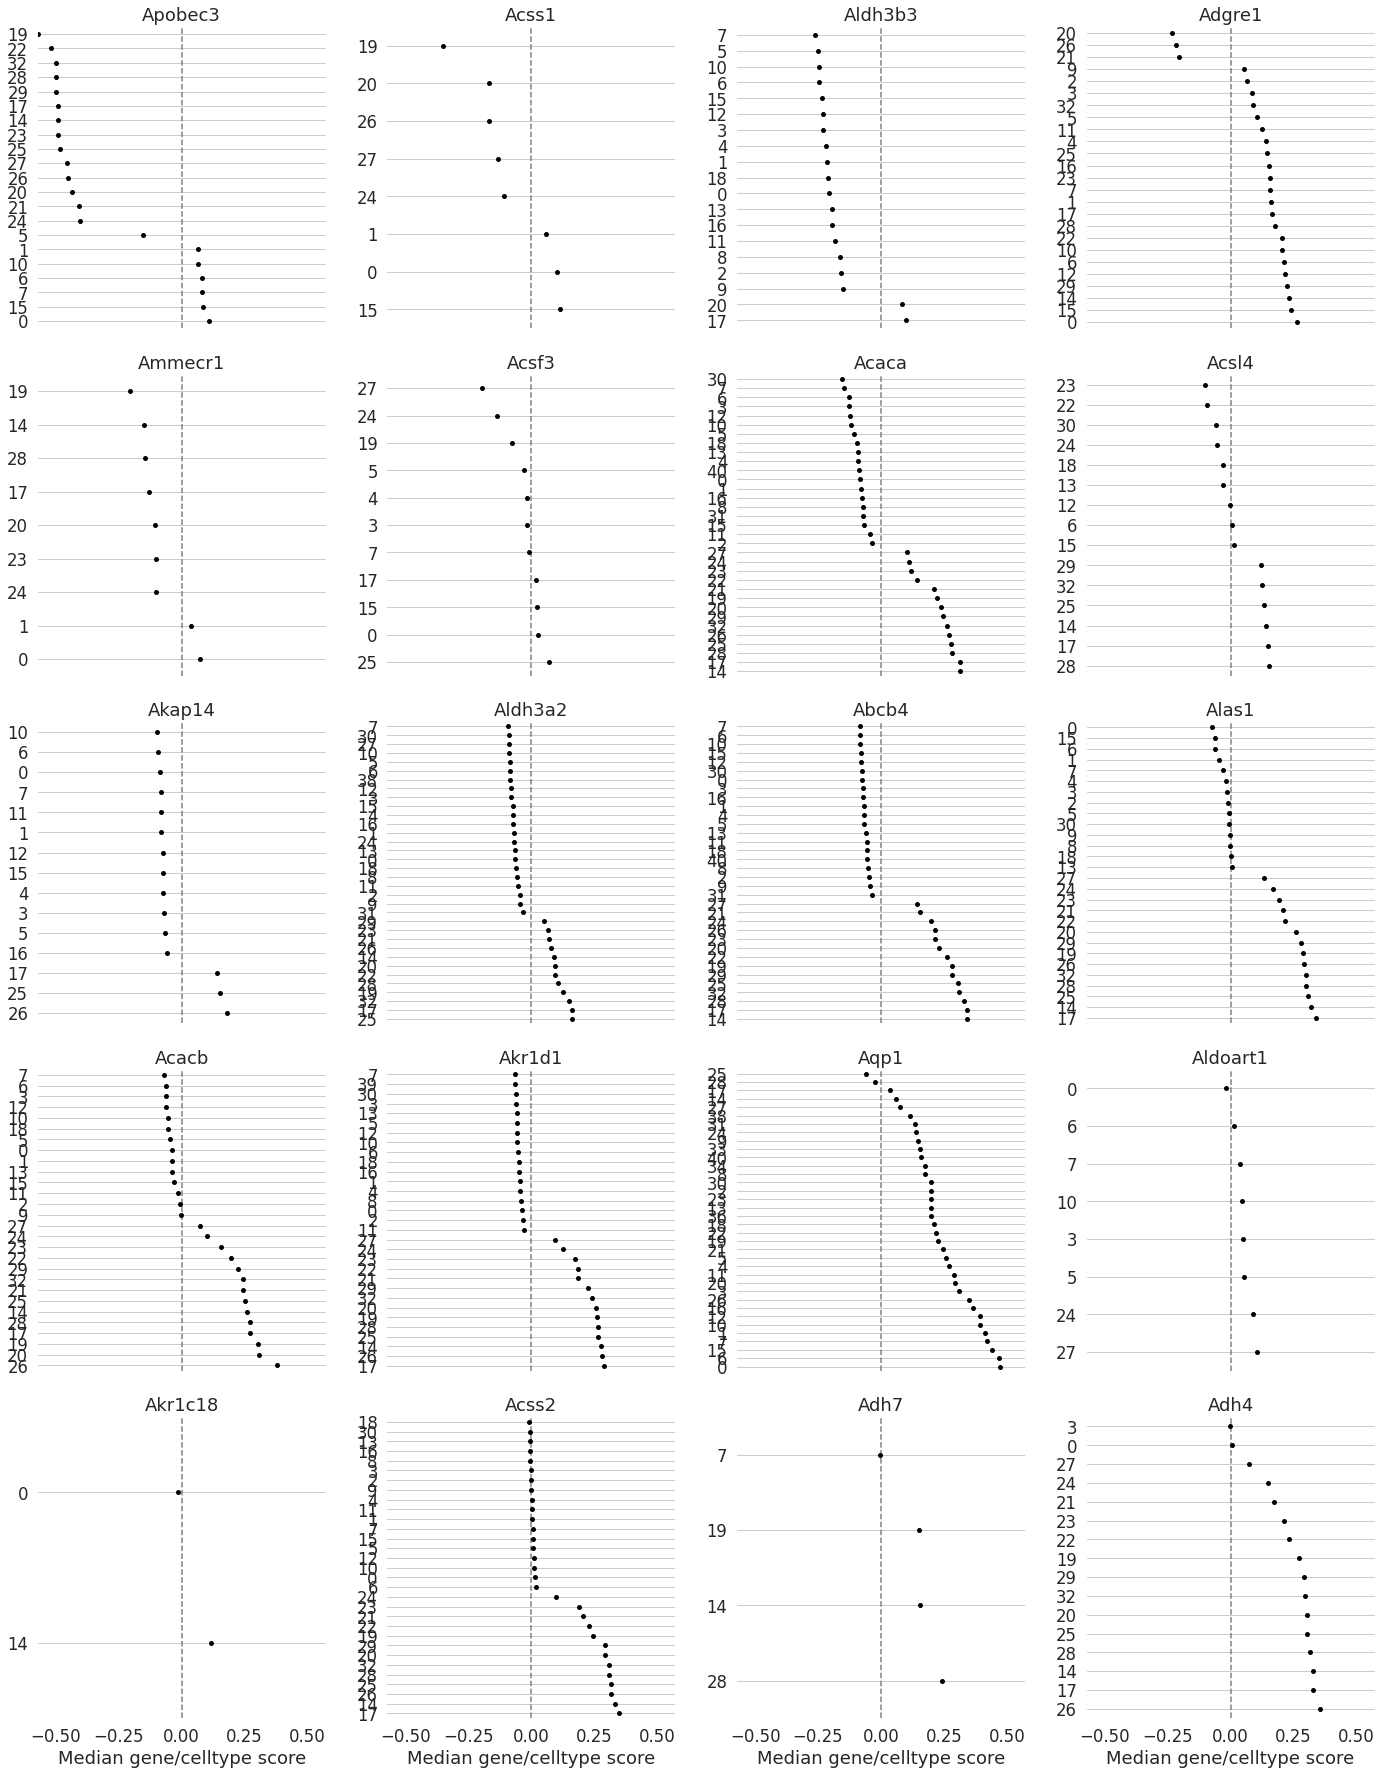

vz_Liver central


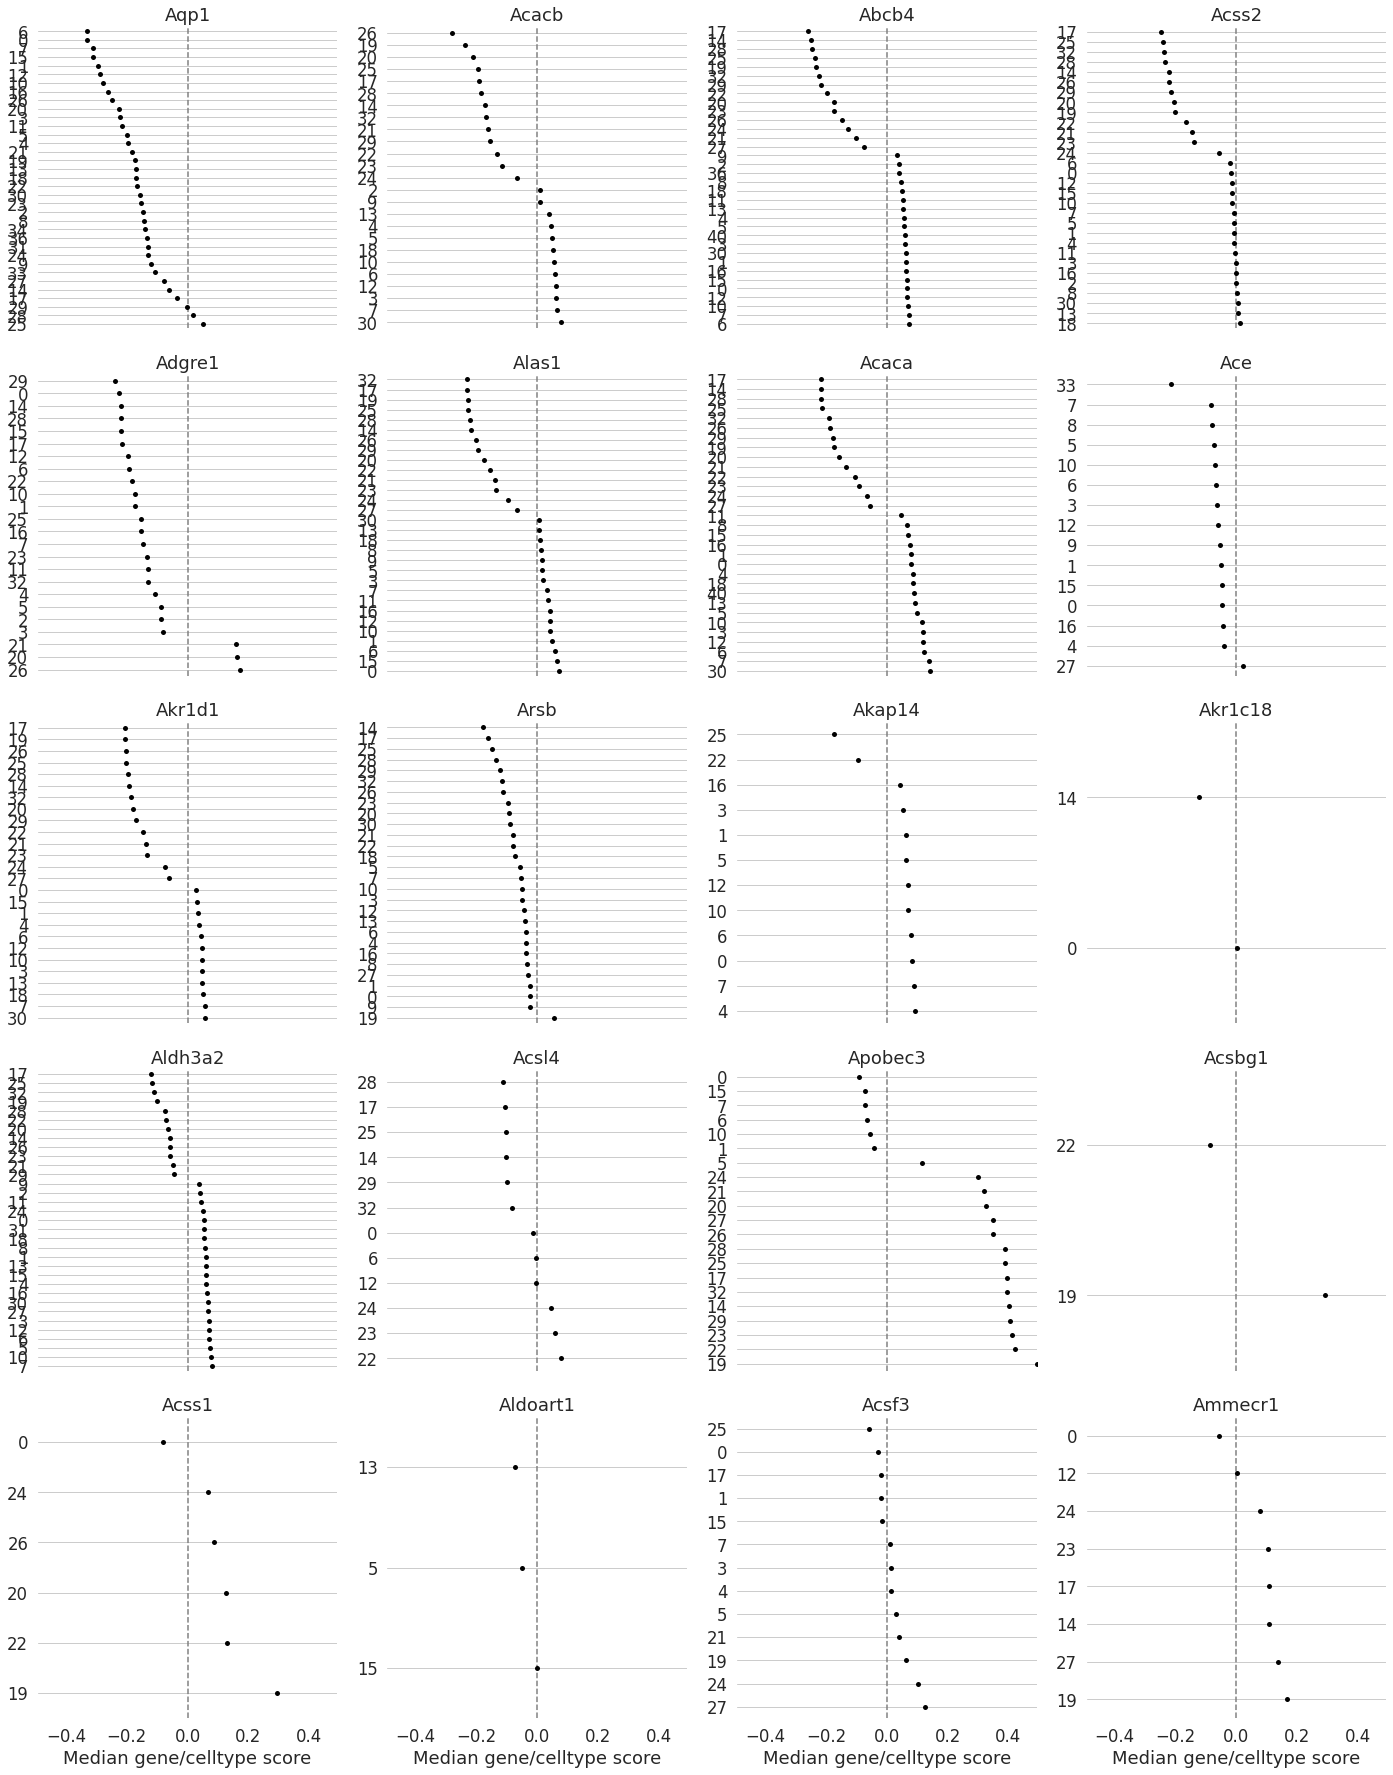

vz_Liver radial
vz_Liver punctate


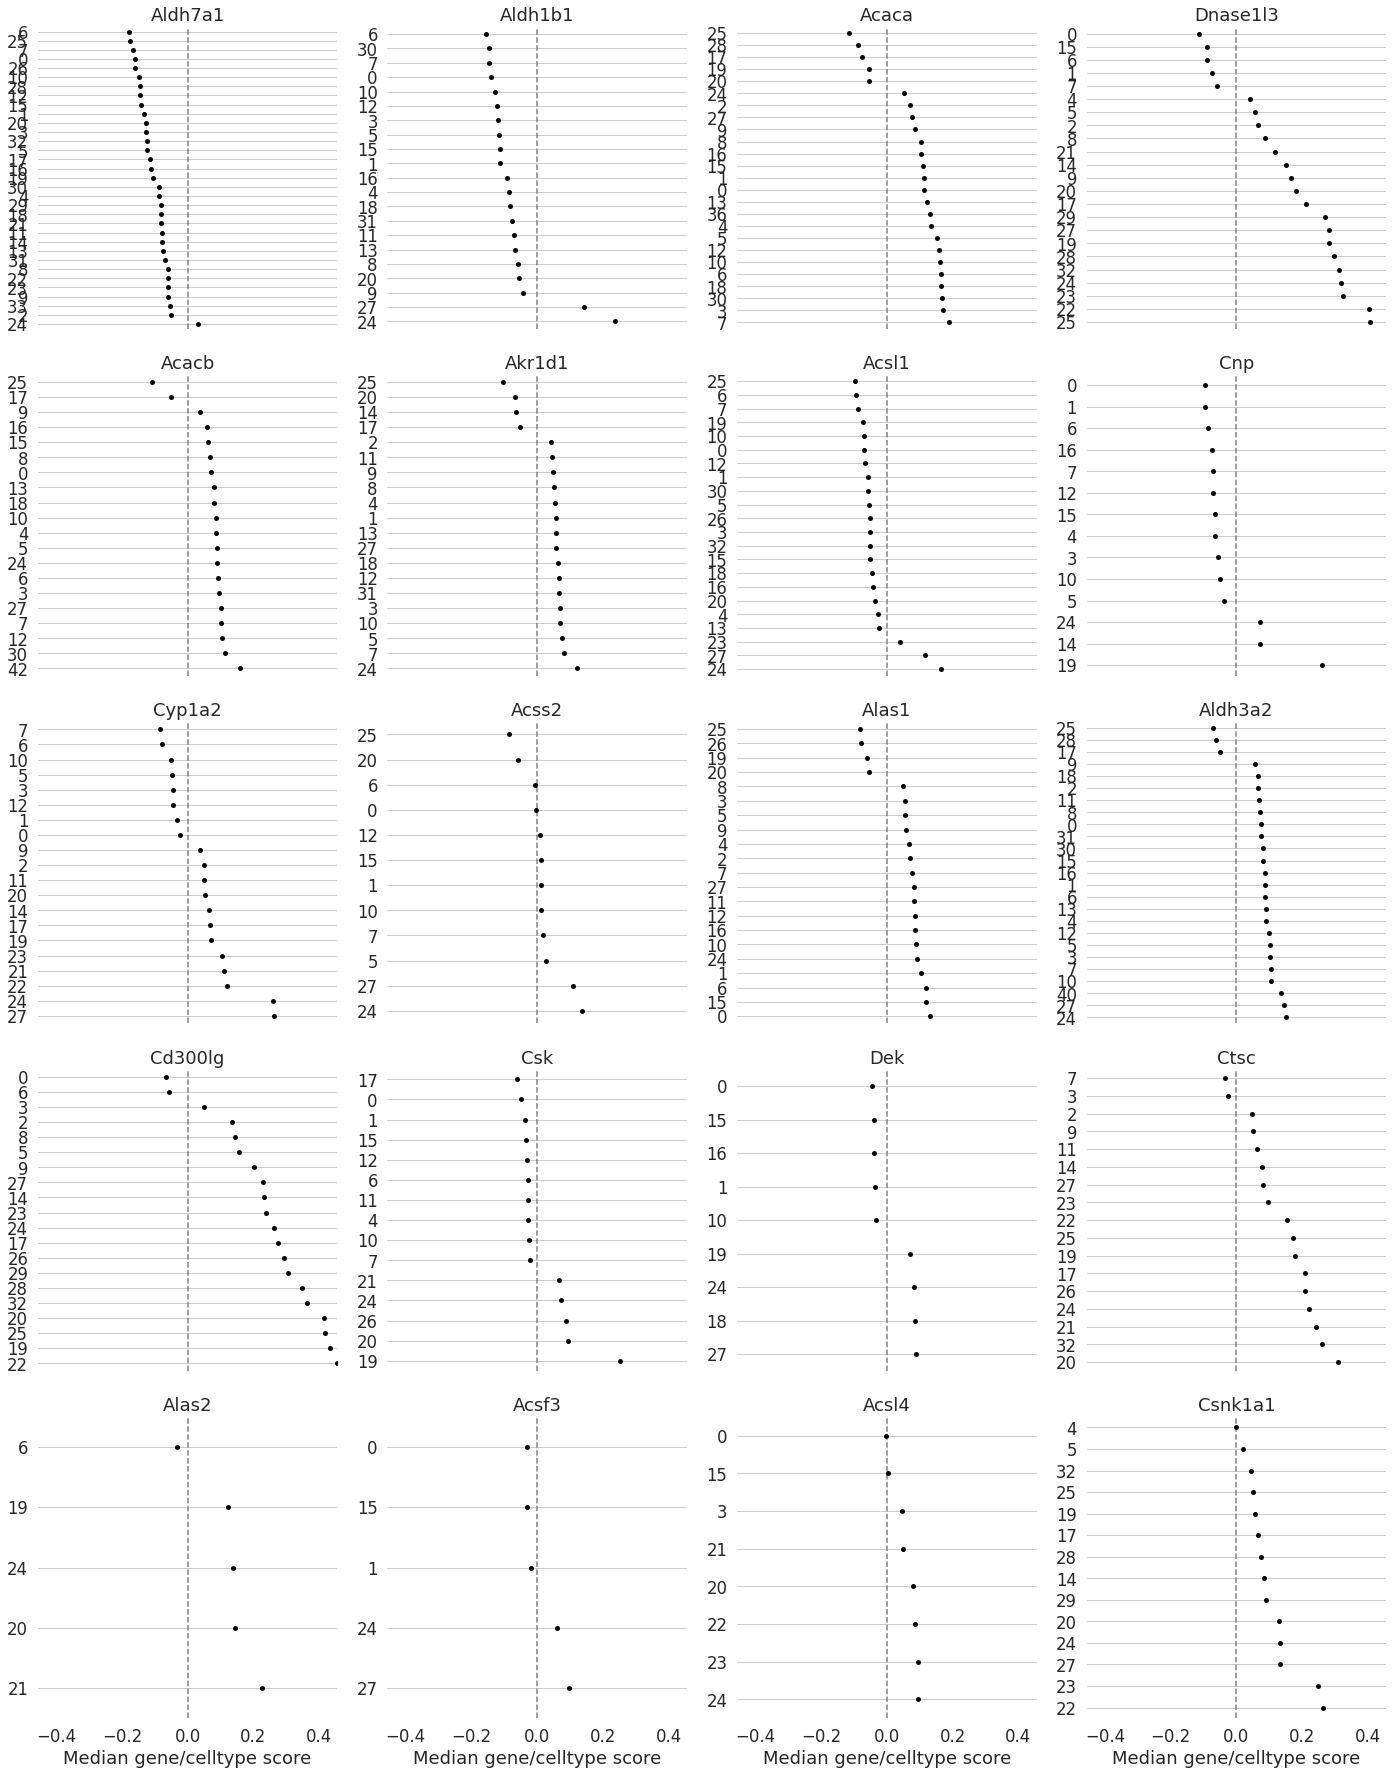

experiment      metric  unique_genes  sigificant_genes  opposite_genes
0         BICCN  peripheral           252               251              92
1         BICCN     central           252               249              96
2         BICCN      radial           251               216               2
3         BICCN    punctate           251               236              10
4      SeqFISH+  peripheral          9805               155               0
5      SeqFISH+     central          9805               113               1
6      SeqFISH+      radial          2423               907             131
7      SeqFISH+    punctate          2423               815              83
8    CZB_Kidney  peripheral           307               273              44
9    CZB_Kidney     central           307               270              58
10   CZB_Kidney      radial           272               250              83
11   CZB_Kidney    punctate           272               250              68
12    CZB_Liver  peripheral           305               249              44
13    CZB_Liver     central           305               240              43
14    CZB_Liver      radial           162               136              67
15    CZB_Liver    punctate           162               136              28
16  vz_Brainmap  peripheral           589               224               3
17  vz_Brainmap     central           589               208               2
18  vz_Brainmap      radial           370                77               0
19  vz_Brainmap    punctate           370               138               3
20     vz_Liver  peripheral           385               380             215
21     vz_Liver     central           385               379             202
22     vz_Liver    punctate           385               323              64

In [237]:
metrics = ['peripheral','central','radial','punctate']
create_plots = True
max_panels = 20
panel_columns = 4

experiment_samples = {
    'BICCN':[
        '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/BICCN_mouse1',
        '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/BICCN_mouse2',
    ],
    'SeqFISH+':[
        '../../nf_pipeline/outputs/SRRS_20220526/gene_ont/seqfish'
    ],
    'CZB_Kidney':[
        '../../nf_pipeline/outputs/SRRS_20220526/gene_ont/CZB_kidney',
    ],
    'CZB_Liver':[
        '../../nf_pipeline/outputs/SRRS_20220526/gene_ont/CZB_liver',
    ],
    'vz_Brainmap':[
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice1',
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice2',
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice3',
    ],
    'vz_Liver':[
        '../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/vz_Liver_mouse1',
        '../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/vz_Liver_mouse2',
    ],
}

data = collections.defaultdict(list)

for experiment,samples in experiment_samples.items():
    for metric in metrics:
        print(experiment,metric)
        
        df = pd.DataFrame()
        for sample in samples:
            f_path = glob.glob(sample+'*'+metric+'*')
            if not f_path:
                continue
                
            sample_df = pd.read_csv(f_path[0])
            sample_df['sample'] = os.path.basename(sample)
            df = pd.concat((df,sample_df))
            
        if df.empty:
            continue
            
        #Collapse all samples in the experiment
        exp_df = df.groupby(['metric','gene','annotation']).agg(
            med_score = ('med_score','median'),
            all_sig = ('bh_p',lambda bh_ps: all((p < 0.05 for p in bh_ps))),
            med_bh_p = ('bh_p','median'),
            num_samples = ('sample','nunique'),
            med_cells = ('num_cells','median'),
            med_gene_spots = ('med_gene_spots','median'),
            med_spots = ('med_spots','median'),
            med_z = ('z','median'),
            med_p = ('p','median'),
        ).reset_index()
        
        #Filter to remove gene/annotation groups that:
        #    1) Aren't significant in all samples
        #    2) Aren't present in all samples
        #    3) Have fewer than 30 median cells over the samples
        exp_df = exp_df[
            exp_df['all_sig']
            & exp_df['num_samples'].eq(df['sample'].nunique())
            & exp_df['med_cells'].ge(40)
        ]

        #Finding genes that are positive and negative in at least 1 cell-type
        genes_with_opposite_effects = (
            exp_df.groupby('gene').filter(
                lambda g: (g['med_score'].gt(0).sum() * g['med_score'].lt(0).sum() > 0)
            )['gene'].unique()
        )
        
        #Add gene counts to the data dict
        data['experiment'].append(experiment)
        data['metric'].append(metric)
        data['unique_genes'].append(df['gene'].nunique())
        data['sigificant_genes'].append(exp_df['gene'].nunique())
        data['opposite_genes'].append(len(genes_with_opposite_effects))
                            
        if not create_plots or len(genes_with_opposite_effects) == 0:
            continue
            
        #For each gene with an opposite effect, plot the median gene-ontology values
        #plot only the significant cell-types
        if not max_panels:
            plot_df = exp_df[exp_df['gene'].isin(genes_with_opposite_effects)]
        else:
            plot_df = exp_df[exp_df['gene'].isin(genes_with_opposite_effects[:max_panels])]
            
        plot_df = plot_df.sort_values('med_score')
        plot_df['annotation'] = plot_df['annotation'].astype(str) #needed for the annots which are ints

        
        sns.set(font_scale=1.5, style='whitegrid') #increase the font size and use a whitegrid background

        g = sns.catplot(
            x = 'med_score', y = 'annotation',
            col = 'gene', col_wrap = panel_columns,
            sharey = False,
            kind = 'strip', jitter = False,
            color = 'black',
            data = plot_df,
        )

        for ax in g.axes.flatten():
            curr_title = ax.get_title()
            ax.set_title(curr_title.split(' = ')[-1])
            ax.axvline(0, linestyle='dashed', color='grey')
            ax.yaxis.grid(True) # show the horizontal gridlines
            ax.xaxis.grid(False) # hide the vertical gridlines

        min_score,max_score = plot_df['med_score'].min(),plot_df['med_score'].max()
        span = max(abs(min_score),abs(max_score))
        g.set(xlim=(-span,span), xlabel='Median gene/celltype score', ylabel='')

        sns.despine(left=True, bottom=True)
        plt.show()
        plt.close()
        
gene_count_df = pd.DataFrame(data)
gene_count_df

# Identifying genes that are significant in only a subset of cell-types

Very similar to the "opposite" analysis above, just identifying genes that are significant in only a subset of all cell-types where they appear.

The "opposite" genes are a subset of these "cell-type dependent" significant genes

Will keep track of cells per ontology and other normalizing data

In [275]:
metrics = ['peripheral','central','radial','punctate']

experiment_samples = {
    'BICCN':[
        '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/BICCN_mouse1',
        '../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/BICCN_mouse2',
    ],
    'SeqFISH+':[
        '../../nf_pipeline/outputs/SRRS_20220526/gene_ont/seqfish'
    ],
    'CZB_Kidney':[
        '../../nf_pipeline/outputs/SRRS_20220526/gene_ont/CZB_kidney',
    ],
    'CZB_Liver':[
        '../../nf_pipeline/outputs/SRRS_20220526/gene_ont/CZB_liver',
    ],
    'vz_Brainmap':[
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice1',
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice2',
        '../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/vz_Brainmap_slice3',
    ],
    'vz_Liver':[
        '../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/vz_Liver_mouse1',
        '../../nf_pipeline/outputs/vz_Liver_20220601_direct/gene_ont/vz_Liver_mouse2',
    ],
}

data = collections.defaultdict(list)

for experiment,samples in experiment_samples.items():
    for metric in metrics:
        print(experiment,metric)
        
        df = pd.DataFrame()
        for sample in samples:
            f_path = glob.glob(sample+'*'+metric+'*')
            if not f_path:
                continue
                
            sample_df = pd.read_csv(f_path[0])
            sample_df['sample'] = os.path.basename(sample)
            df = pd.concat((df,sample_df))
            
        if df.empty:
            continue
            
        #Collapse all samples in the experiment
        exp_df = df.groupby(['metric','gene','annotation']).agg(
            med_score = ('med_score','median'),
            all_samples_sig = ('bh_p',lambda bh_ps: all((p < 0.05 for p in bh_ps))),
            any_samples_sig = ('bh_p',lambda bh_ps: any((p < 0.05 for p in bh_ps))),
            med_bh_p = ('bh_p','median'),
            num_samples = ('sample','nunique'),
            med_cells = ('num_cells','median'),
            med_gene_spots = ('med_gene_spots','median'),
            med_spots = ('med_spots','median'),
        ).reset_index()
        
        #Filter to remove gene/annotation groups that:
        #    1) Aren't present in all samples
        #    2) Have fewer than 30 median cells over the samples
        exp_df = exp_df[
            exp_df['num_samples'].eq(df['sample'].nunique())
            & exp_df['med_cells'].ge(40)
        ]
        
        #Finding cell-type dependent significant genes which meet the following criteria
        #1) Significant in every sample in at least one cell-type
        #2) Insignificant in at least one sample in at least one cell-type
        #
        #the ternary is so that the False's are na's that can be dropped
        celltype_dependent_genes = exp_df.groupby('gene').apply(
            lambda g: True if (g['all_samples_sig'].any() and not(g['any_samples_sig'].all())) else None
        ).dropna().index.to_list()
        
        #Number of genes that NEVER significant in any cell-type in any sample
        num_genes_never_sig = exp_df.groupby('gene')['any_samples_sig'].apply(
            lambda v: None if v.any() else True
        ).dropna().size

        
        #Add gene counts to the data dict
        data['experiment'].append(experiment)
        data['metric'].append(metric)
        data['unique_genes'].append(df['gene'].nunique())
        data['celltype_dependent_genes'].append(len(celltype_dependent_genes))
        data['never_sigificant_genes'].append(num_genes_never_sig)
    
gene_count_df = pd.DataFrame(data).set_index('experiment')
gene_count_df

BICCN peripheral
BICCN central
BICCN radial
BICCN punctate
SeqFISH+ peripheral
SeqFISH+ central
SeqFISH+ radial
SeqFISH+ punctate
CZB_Kidney peripheral
CZB_Kidney central
CZB_Kidney radial
CZB_Kidney punctate
CZB_Liver peripheral
CZB_Liver central
CZB_Liver radial
CZB_Liver punctate
vz_Brainmap peripheral
vz_Brainmap central
vz_Brainmap radial
vz_Brainmap punctate
vz_Liver peripheral
vz_Liver central
vz_Liver radial
vz_Liver punctate


metric  unique_genes  celltype_dependent_genes  \
experiment                                                        
BICCN        peripheral           252                       216   
BICCN           central           252                       230   
BICCN            radial           251                       111   
BICCN          punctate           251                       100   
SeqFISH+     peripheral          9805                        97   
SeqFISH+        central          9805                        75   
SeqFISH+         radial          2423                         1   
SeqFISH+       punctate          2423                        54   
CZB_Kidney   peripheral           307                       242   
CZB_Kidney      central           307                       251   
CZB_Kidney       radial           272                         1   
CZB_Kidney     punctate           272                        12   
CZB_Liver    peripheral           305                       162   
CZB_Liver       central           305                       159   
CZB_Liver        radial           162                         1   
CZB_Liver      punctate           162                         4   
vz_Brainmap  peripheral           589                        77   
vz_Brainmap     central           589                        67   
vz_Brainmap      radial           370                        50   
vz_Brainmap    punctate           370                        57   
vz_Liver     peripheral           385                       373   
vz_Liver        central           385                       373   
vz_Liver       punctate           385                       303   

             never_sigificant_genes  
experiment                           
BICCN                             0  
BICCN                             0  
BICCN                            13  
BICCN                             1  
SeqFISH+                       5453  
SeqFISH+                       5495  
SeqFISH+                          4  
SeqFISH+                         96  
CZB_Kidney                       34  
CZB_Kidney                       37  
CZB_Kidney                        0  
CZB_Kidney                        0  
CZB_Liver                        41  
CZB_Liver                        50  
CZB_Liver                         0  
CZB_Liver                         0  
vz_Brainmap                      35  
vz_Brainmap                      37  
vz_Brainmap                      13  
vz_Brainmap                       2  
vz_Liver                          0  
vz_Liver                          0  
vz_Liver                         16